In [0]:
! pip install arviz
! pip install --upgrade pymc3>=3.8

     |████████████████████████████████| 1.5MB 2.8MB/s 
     |████████████████████████████████| 4.1MB 47.2MB/s 
     |████████████████████████████████| 327kB 46.7MB/s 


In [0]:
import numpy as np
from numpy.random import randn, binomial, multinomial
import pandas as pd
import math
import random

import sklearn.datasets
import sklearn.model_selection
from sklearn.model_selection import train_test_split

from scipy import stats
from scipy import optimize
from scipy.stats import beta, uniform, gamma, poisson
import statsmodels as sm
import patsy as pt
import pymc3 as pm
from pymc3.backends.tracetab import trace_to_dataframe

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")
np.set_printoptions(precision=4)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


---
# Q1 - Exploring the effects of the dataset size on the MLE and MAP estimates
---

In this section, we will investigate the effects of the sample size on the MLE and MAP estimates for:
1. Normally distributed data
2. Poisson distributed data

## Problem 1. Normally Distributed Data

Generate synthetic data based on: <br>
$Y = \alpha + \sum_{i=0}^{d} \beta_i X_i + \epsilon$ <br>
where: <br>
 $\forall i \in \{1, ..., d\}$, $\forall j \in \{1, ..., N\}$, $X_{i,j} \sim \mathcal{N}(\mu_i, \sigma^2_i)$ are user-defined,<br>
$d$ represents total number of features, $N$ represents total number of samples, <br>
$\alpha$ is the intercept, $\beta$ is the coefficient for covariate $X_i$ and is a vector in $\mathbb{R}^d$, <br>
and $\epsilon$ represents the observation error according to $\epsilon \sim \mathcal{N}(0, \sigma_{e}^2)$. <br>
Hence, due to affine property of Gaussians, $Y \sim(\mu, \sigma_{e}^2)$ where $\mu = \alpha + \sum_{i=0}^{d} \beta_i X_i$. 

The true values of $\alpha, \beta,$ and $\sigma_e$ are defined by the user.


In [0]:
np.random.seed(42)

class DataGenerator:
    
    @staticmethod
    def generator_normal(size, predictor_parameters, true_model_parameters):
        
        mus = predictor_parameters['mus']
        sigmas = predictor_parameters['sigmas']
        
        alpha = true_model_parameters['alpha']
        beta = true_model_parameters['beta']
        sigma = true_model_parameters['sigma']

        # generate predictor variable
        X = []
        
        if len(mus) != len(sigmas) and len(mus)!=len(beta):
            print('Error : mus and sigmas are the mean and variance of the predictor variables')
            print('And beta must have the same size as mus')
            return None
        
        for i in range(len(mus)):
            m = mus[i]
            s = sigmas[i]
            x = m + np.random.randn(size)*s
            X.append(x)
        
        # simulate outcome variable
        Y = alpha
        for i in range(len(beta)):
            Y += beta[i]*X[i]
        Y += np.random.randn(size)*sigma
        
        return np.array(X).T, np.array(Y)

    @staticmethod
    def generator_poisson(size, predictor_parameters, true_model_parameters):
        
        mus = predictor_parameters['mus']
        
        alpha = true_model_parameters['alpha']
        beta = true_model_parameters['beta']
        sigma = true_model_parameters['sigma']

        # generate predictor variable
        X = []
        
        if len(mus)!=len(beta):
            print('And beta must have the same size as mus')
            return None
        
        for i in range(len(mus)):
            mu = mus[i]
            x = np.random.poisson(m, 100).astype('float64')
            X.append(x)
        
        # simulate outcome variable
        Y = alpha
        for i in range(len(beta)):
            Y += beta[i]*X[i]
        Y += np.random.randn(size)*sigma
        
        return np.array(X).T, np.array(Y)

    @staticmethod
    def plot_hist_data(X, Y):
        d = X.shape[1]
        nb_col = d
        nb_row = 2
        fig, axes = plt.subplots(nb_row, nb_col, sharex=True, sharey=False, figsize=(20,8))
        
        for i in range(d):
            row = 0
            col = i
            axes[row][col].hist(X.T[i])
            if i == 0:
                axes[row][col].set_ylabel('Count')
            # axes[row][col].set_xlabel('X{}'.format(i+1))
        
        for i in range(d):
            row = 1
            col = i
            axes[row][col].scatter(X.T[i], Y)
            if i == 0:
                axes[row][col].set_ylabel('Y')
            axes[row][col].set_xlabel('X{}'.format(i+1))

        plt.show()

Define two kinds of estimators: MLE and MAP. <br>
In the case of MLE, priors follow a uniform distribution over the range of possible values of $\alpha$, $\beta$ and $\sigma_e$. <br>
In the case of MAP, centered Gaussian distributions are used as priors for $\alpha$ and $\beta$ while a Half Gaussian distribution prior is used for $\sigma_e$. <br>
Absolute errors between the true parameters and estimated parameters are then computed for varying sample size (from 5 to 100).

In [0]:
np.random.seed(42)

class Estimator:
    
    @staticmethod
    def get_estimator(X_train, 
                      y_train,  
                      prior_parameters,
                      estimator_type='mle'):
        
        basic_model = pm.Model()
        
        with basic_model:

            if estimator_type == 'mle':
                # Priors for unknown model parameters
                alpha = pm.Uniform('alpha',
                                  lower=prior_parameters['alpha']['lower'],
                                  upper=prior_parameters['alpha']['upper'])
                beta = pm.Uniform('beta', 
                                  lower=prior_parameters['beta']['lower'],
                                  upper=prior_parameters['beta']['upper'],
                                  shape=X_train.shape[1])
                sigma = pm.Uniform('sigma',
                                  lower=prior_parameters['sigma']['lower'],
                                  upper=prior_parameters['sigma']['upper']) 
            elif estimator_type == 'map':
                # Priors for unknown model parameters
                alpha = pm.Normal('alpha', 
                                  mu=prior_parameters['alpha']['mu'], 
                                  sigma=prior_parameters['alpha']['sigma'])
                beta = pm.Normal('beta', 
                                 mu=prior_parameters['beta']['mu'], 
                                 sigma=prior_parameters['beta']['sigma'], 
                                 shape=X_train.shape[1])
                sigma = pm.HalfNormal('sigma', 
                                      sigma=prior_parameters['sigma'])
            else:
                raise ValueError('Estimator is MLE or MAP')

            # Expected value of outcome
            mu = alpha 
            for i in range(X_train.shape[1]):
                mu += beta[i]*X_train[:, i]
            
            # Likelihood (sampling distribution) of observations
            Y_obs = pm.Normal('Y_obs', mu=mu, sigma=sigma, observed=y_train)
        
        # uses the Broyden–Fletcher–Goldfarb–Shanno (BFGS) optimization algorithm by default to find the maximum of the log-posterior
        estimator = pm.find_MAP(model=basic_model)

        return estimator
    
    @staticmethod
    def compute_error_estimator(estimator, true_model_parameters):
        """
        In case the true parameters are known
        """
        alpha_error = np.abs(estimator['alpha'] - true_model_parameters['alpha'])
        beta_error = np.abs(estimator['beta'] - true_model_parameters['beta'])
        sigma_error = np.abs(estimator['sigma'] - true_model_parameters['sigma'])
        
        return np.append(np.append(alpha_error, beta_error), sigma_error)
    
    @staticmethod
    def study_estimator(data, 
                        target, 
                        train_size, 
                        prior_parameters,
                        true_model_parameters,
                        estimator_type='mle', 
                        nb_test_sample=None):

        # Split the dataset to vary the number of sample training size accordingly
        if train_size != 1.0:
          X_train, X_val, y_train, y_val = train_test_split(data, 
                                                            target, 
                                                            test_size=1-train_size, 
                                                            random_state=42)

          estimator = Estimator.get_estimator(X_train, 
                                              y_train, 
                                              prior_parameters=prior_parameters,
                                              estimator_type=estimator_type)
        
        elif train_size == 1.0:
          estimator = Estimator.get_estimator(data, 
                                              target, 
                                              prior_parameters=prior_parameters,
                                              estimator_type=estimator_type)

        estimator_error = Estimator.compute_error_estimator(estimator, true_model_parameters)
        error = np.array([estimator_error])
        
        # error = [alpha_error, beta_1_error, beta_2_error, ..., beta_6_error, sigma_error]
        return estimator, error
    
    @staticmethod
    def run_analysis(data, 
                     target, 
                     train_sizes, 
                     prior_parameters,
                     true_model_parameters,
                     estimator_type='mle', 
                     nb_test_sample=None):

        results = []
        for train_size in train_sizes:
            estimator, error = Estimator.study_estimator(data=data,
                                                         target=target,
                                                         train_size=train_size,
                                                         prior_parameters=prior_parameters,
                                                         true_model_parameters=true_model_parameters,
                                                         estimator_type=estimator_type,
                                                         nb_test_sample=nb_test_sample)

            results.append(np.append(np.array(train_size*100), error))
        columns = ["Size", "alpha_error"]
        l = len(results[0])
        for i in range(6):
            columns.append("beta_{}_error".format(i+1))
        columns.append("sigma_error")
        df_errors = pd.DataFrame(results, columns=columns)
        return df_errors
    
    @staticmethod
    def study_synthetics(N,
                         data_dist,
                         predictor_parameters,
                         prior_mle_parameters,
                         prior_map_parameters,
                         true_model_parameters,
                         nb_points=20):
        
        if data_dist == 'normal':
            X, Y = DataGenerator.generator_normal(N,
                                                  predictor_parameters=predictor_parameters,
                                                  true_model_parameters=true_model_parameters)

        elif data_dist == 'poisson':
            X, Y = DataGenerator.generator_poisson(N,
                                                   predictor_parameters=predictor_parameters,
                                                   true_model_parameters=true_model_parameters)                             
        
        train_sizes = np.linspace(0.05, 1.00, nb_points)
        
        df_error_mle = Estimator.run_analysis(data=X, 
                                 target=Y, 
                                 train_sizes=train_sizes, 
                                 prior_parameters=prior_mle_parameters,
                                 true_model_parameters=true_model_parameters,
                                 estimator_type='mle', 
                                 nb_test_sample=None)
        
        df_error_map = Estimator.run_analysis(data=X, 
                                 target=Y, 
                                 train_sizes=train_sizes, 
                                 prior_parameters=prior_map_parameters,
                                 true_model_parameters=true_model_parameters,
                                 estimator_type='map', 
                                 nb_test_sample=None)
        
        return df_error_mle, df_error_map
    
    def plot_estimators_comparison_mle_map(df_error_mle_means, df_error_mle_min, df_error_mle_max, df_error_map_means, df_error_map_min, df_error_map_max):
    
        columns = df_error_map.columns
        l = len(columns)
        if l < 2:
            raise ValueError("The parameters estimator error must be computed")

        nb_estimators = l-1
        fig, ax = plt.subplots(math.ceil(nb_estimators/3), 3, sharex=True, figsize=(20,10))

        for i in range(1, l):
            sizes = df_error_mle.Size.values

            row = (i-1)//3
            col = (i-1)%3

            ax[row, col].errorbar(sizes, df_error_mle_means[columns[i]], np.array([df_error_mle_min[columns[i]],df_error_mle_max[columns[i]]]), capsize=5, label="MLE")
            ax[row, col].errorbar(sizes, df_error_map_means[columns[i]], np.array([df_error_map_min[columns[i]],df_error_map_max[columns[i]]]), capsize=5, label="MAP")
            ax[row, col].legend(loc='upper right')
            ax[row, col].set_xticks(range(10, 110, 10))
            if row == 2:
                ax[row,col].set_xlabel("Sample Size")
            ax[row, col].set_ylabel("Error")
            ax[row, col].set_title(columns[i], size=10)
        ax[1,2].set_xlabel("Sample Size")
        ax[1,2].xaxis.set_tick_params(which='both', labelbottom=True, labeltop=False)
        fig.delaxes(ax[2,2])
        plt.savefig("Errors.png")
        plt.show()

Define the parameters for the inputs, model and priors. <br>
Parameters for the inputs $X_i \sim \mathcal{N}(\mu_i, \sigma^2_i)$ are $\mu_i$ and $\sigma_i$ where $i \in \{1, ..., d\}$. <br>
Parameters for the linear regression model $Y \sim(\mu, \sigma_{e}^2)$ where $\mu = \alpha + \sum_{i=0}^{d} \beta_i X_i$ are $\alpha$, $\beta_i$ and $\sigma_e$ where $i \in \{1, ..., d\}$. <br>

In [0]:
# Maximum number of sample size
N = 100

predictor_parameters = {
    'mus': [5, 7, 10, 20, -10, 3],
    'sigmas': [1.5, 0.5, 2, 4, 10, 5]
}

true_model_parameters = {
    'alpha': -5,
    'beta': [5, 10, 1, 3, -7, 2],
    'sigma': 2
}

prior_mle_parameters = {
    'alpha': {
        'lower': -15, 
        'upper': 15,
    },
    'beta': {
        'lower': -15, 
        'upper': 15,
    },
    'sigma': {
        'lower': 0, 
        'upper': 10,
    }
}

prior_map_parameters = {
    'alpha':{
        'mu': 0,
        'sigma': 10
    },
    'beta':{
        'mu': 0,
        'sigma': 10
    },
    'sigma': 5
}

Plot the histogram of the data generated based on the true parameters.

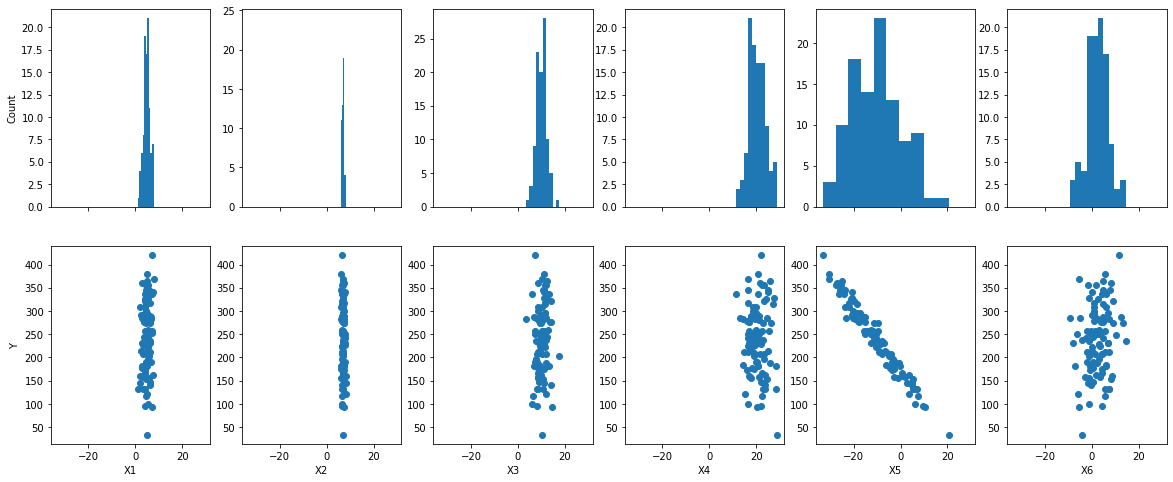

In [0]:
X, Y = DataGenerator.generator_normal(N,
                                      predictor_parameters=predictor_parameters,
                                      true_model_parameters=true_model_parameters)

DataGenerator.plot_hist_data(X, Y)

Compute the error between true and estimated parameters for both MLE and MAP methods. Repeat the process for 5 times.

In [0]:
df_error_mle_all = pd.DataFrame()
df_error_map_all = pd.DataFrame()
N_trials = 5
for i in range(N_trials):
    df_error_mle, df_error_map = Estimator.study_synthetics(N,
                                                            'normal', 
                                                            predictor_parameters,
                                                            prior_mle_parameters,
                                                            prior_map_parameters,
                                                            true_model_parameters,
                                                            nb_points=20)
    df_error_mle_all = pd.concat((df_error_mle_all, df_error_mle))
    df_error_map_all = pd.concat((df_error_map_all, df_error_map))

logp = 39.125, ||grad|| = 7.0167e+06: 100%|██████████| 650/650 [00:00<00:00, 1467.32it/s] 
logp = -45.773, ||grad|| = 0.66249: 100%|██████████| 190/190 [00:00<00:00, 1486.74it/s] 
logp = -54.612, ||grad|| = 0.28783: 100%|██████████| 105/105 [00:00<00:00, 1607.82it/s] 
logp = -64.066, ||grad|| = 0.1336: 100%|██████████| 112/112 [00:00<00:00, 1559.90it/s] 
logp = -73.95, ||grad|| = 0.33598: 100%|██████████| 98/98 [00:00<00:00, 1614.16it/s]  
logp = -85.553, ||grad|| = 0.14971: 100%|██████████| 163/163 [00:00<00:00, 1501.14it/s] 
logp = -101.99, ||grad|| = 0.32785: 100%|██████████| 98/98 [00:00<00:00, 1420.25it/s]  
logp = -109.95, ||grad|| = 0.5684: 100%|██████████| 127/127 [00:00<00:00, 1473.29it/s] 
logp = -119.1, ||grad|| = 1.6408: 100%|██████████| 100/100 [00:00<00:00, 1469.08it/s]
logp = -130.91, ||grad|| = 0.23169: 100%|██████████| 95/95 [00:00<00:00, 1508.98it/s]  
logp = -139.69, ||grad|| = 0.13873: 100%|██████████| 103/103 [00:00<00:00, 1537.64it/s] 
logp = -149.33, ||grad|| = 1

Plot the average errors for the different sample size. The error bars represent the min-max range of the errors over the 5 runs.

In [0]:
by_row_index = df_error_mle_all.groupby(df_error_mle_all.index)
df_error_mle_means = by_row_index.mean()
df_error_mle_min = by_row_index.min()
df_error_mle_max = by_row_index.max()
by_row_index = df_error_map_all.groupby(df_error_map_all.index)
df_error_map_means = by_row_index.mean()
df_error_map_min = by_row_index.min()
df_error_map_max = by_row_index.max()

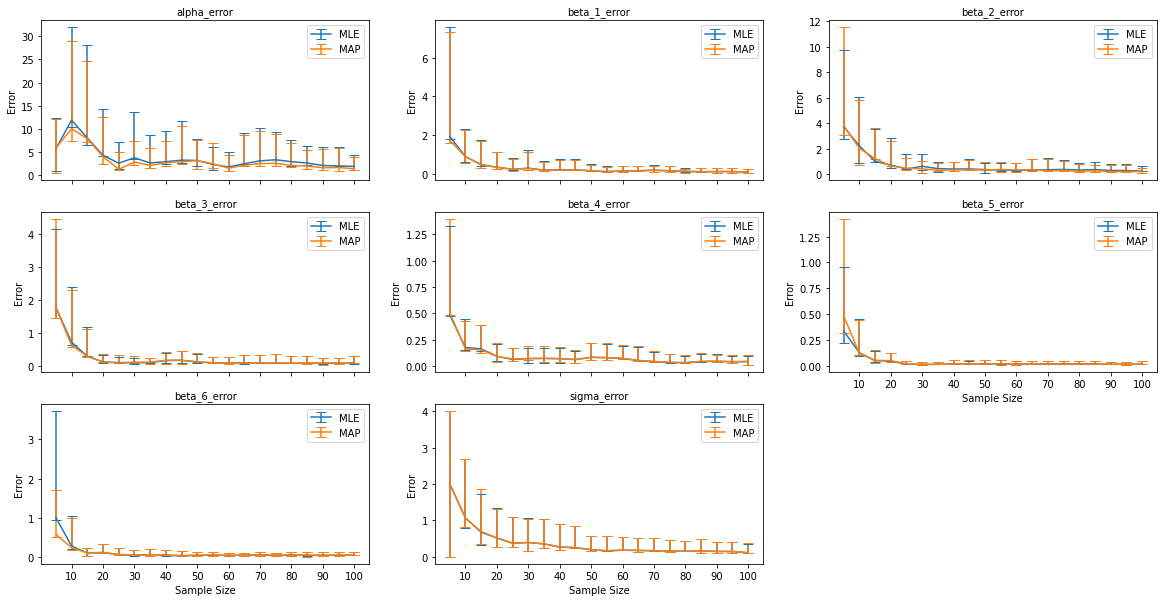

In [0]:
Estimator.plot_estimators_comparison_mle_map(df_error_mle_means, df_error_mle_min, df_error_mle_max,
                                             df_error_map_means, df_error_map_min, df_error_map_max)

## Problem 2. Poisson Distributed Data

Repeat the same experiment with Poisson distributed data.
Generate synthetic data based on: <br>
$Y = \alpha + \sum_{i=0}^{d} \beta_i X_i + \epsilon$ <br>
where: <br>
 $\forall i \in \{1, ..., d\}$, $\forall j \in \{1, ..., N\}$, $X_{i,j} \sim Pois(\mu_i)$ are user-defined,<br>
$d$ represents total number of features, $N$ represents total number of samples, <br>
$\alpha$ is the intercept, $\beta$ is the coefficient for covariate $X_i$ and is a vector in $\mathbb{R}^d$, <br>
and $\epsilon$ represents the observation error according to $\epsilon \sim \mathcal{N}(0, \sigma_{e}^2)$. <br>
Hence, due to affine property of Gaussians, $Y \sim(\mu, \sigma_{e}^2)$ where $\mu = \alpha + \sum_{i=0}^{d} \beta_i X_i$. 

Define the parameters for the inputs, model and priors. <br>
Parameters for the inputs $X_i \sim Pois(\mu_i)$ are $\mu_i$ where $i \in \{1, ..., d\}$. <br>
Parameters for the linear regression model $Y \sim(\mu, \sigma_{e}^2)$ where $\mu = \alpha + \sum_{i=0}^{d} \beta_i X_i$ are $\alpha$, $\beta_i$ and $\sigma_e$ where $i \in \{1, ..., d\}$. <br>


In [0]:
# Maximum number of sample size
N = 100

predictor_parameters = {
    'mus': [5, 7, 10, 20, 15, 3],
}

true_model_parameters = {
    'alpha': -5,
    'beta': [5, 10, 1, 3, -7, 2],
    'sigma': 2
}

prior_mle_parameters = {
    'alpha': {
        'lower': -15, 
        'upper': 15,
    },
    'beta': {
        'lower': -15, 
        'upper': 15,
    },
    'sigma': {
        'lower': 0, 
        'upper': 10,
    }
}

prior_map_parameters = {
    'alpha':{
        'mu': 0,
        'sigma': 10
    },
    'beta':{
        'mu': 0,
        'sigma': 10
    },
    'sigma': 5
}

Plot the histogram of the data generated based on the true parameters.

In [0]:
X, Y = DataGenerator.generator_poisson(N,
                              predictor_parameters=predictor_parameters,
                              true_model_parameters=true_model_parameters)

DataGenerator.plot_hist_data(X, Y)

NameError: ignored

Compute the error between true and estimated parameters for both MLE and MAP methods. Repeat the process for 5 times.

In [0]:
df_error_mle_all = pd.DataFrame()
df_error_map_all = pd.DataFrame()
N_trials = 5
for i in range(N_trials):
    df_error_mle, df_error_map = Estimator.study_synthetics(N, 
                                                            'poisson',
                                                            predictor_parameters,
                                                            prior_mle_parameters,
                                                            prior_map_parameters,
                                                            true_model_parameters,
                                                            nb_points=20)
    df_error_mle_all = pd.concat((df_error_mle_all, df_error_mle))
    df_error_map_all = pd.concat((df_error_map_all, df_error_map))

In [0]:
by_row_index = df_error_mle_all.groupby(df_error_mle_all.index)
df_error_mle_means = by_row_index.mean()
df_error_mle_min = by_row_index.min()
df_error_mle_max = by_row_index.max()
by_row_index = df_error_map_all.groupby(df_error_map_all.index)
df_error_map_means = by_row_index.mean()
df_error_map_min = by_row_index.min()
df_error_map_max = by_row_index.max()

Plot the average errors for the different sample size. The error bars represent the min-max range of the errors over the 5 runs.

In [0]:
Estimator.plot_estimators_comparison_mle_map(df_error_mle_means, df_error_mle_min, df_error_mle_max,
                                             df_error_map_means, df_error_map_min, df_error_map_max)

---
# Q2 Exploring the effects of the prior on the MAP estimates
---
We explore various scenerios, to determine the effect of the prior on the MAP solution. We start with two classic examples (coin flip and dice throw) and then move on to a more common distribution. The different distributions explored:
- Binomial distribution (coin flip)
- Multinomial distribution (dice throw)
- Normal distribution
- Poisson distribution

To find the MAP, we use two methods: the BFGS algorithm and the MCMC sampling. The estimates obtained are then averaged between the two methods.

## Problem 1: Coin Flip (Binomial distribution)

We start with a basic problem.

**Problem Setup:** <br>
Suppose we want to determine if a coin is fair one. 
We can model this by using a Binomial distribution, where the outcome of Heads=1, and Tails=0. 

**Model:** <br>
We can model the outcomes with a Binomial Distribution of $k$ independent trials, and for $N$ samples. ie, 2 coin flips ($k$), 5 times ($N$). A suitable choice of prior would be the Beta distribution as it is conjugate to the Binomial. 

To examine the effect of the prior on MAP, we vary the parameters of the Beta distribution to change the shape of the distribution, reflecting our Prior knowledge. 

In [0]:
''' Define a Binomial distribution'''
np.random.seed(23)

# True parameter value  - Biased coin with 70% chance of Heads
true_p = 0.7

# Sample size; ie. How many independent coin flips in one sample
N = 2

# Number of samples drawn in dataset; ie. How many samples of sample_size=N were drawn
num_samples = 5

# Generate random data based on true_theta
x = binomial(N, true_p, size=num_samples)
sns.countplot(x)
plt.xlabel('Number of heads')

Above plot counts the samples, and the respective number of heads. 

###Uniform Prior
(Assume fair coin) <br>
We sample the data we have with MCMC 1000 times, to generate an estimate for the posterior. The MAP is then the peak of the posterior. 

In [0]:
fig, ax = plt.subplots(1, 1)
fig.suptitle('Uniform Distribution')
uniform_x = np.linspace(uniform.ppf(0.01),
                        uniform.ppf(0.99), 100)
uniform_dist = uniform()
ax.plot(uniform_x, uniform_dist.pdf(uniform_x), 'k-', lw=2)
print('Mean of Uniform distribution: {:.2f}'.format(uniform_x.mean()))

In [0]:
model = pm.Model()
with model:
    # Priors for unknown model parameters
    p = pm.Uniform('p')
    # Expected value of outcome
    y_obs = pm.Binomial('y', n=N, p=p, observed=x)

    # Sample from posterior distribution
    step = pm.NUTS()
    trace = pm.sample(1000, step)
bfgs_estimate = pm.find_MAP(model=model)['p'].item()
mcmc_estimate = pm.summary(trace)['mean'][0]
ax = pm.plot_posterior(trace)

In [0]:
avg_estimate = (mcmc_estimate + bfgs_estimate) / 2
error = abs(true_p - avg_estimate)
print('\nMAP Estimate (BFGS method) = {:.2f}'.format(bfgs_estimate))
print('MAP Estimate (MCMC method) = {:.2f}'.format(mcmc_estimate))
print('MAP Estimate (Averaged) = {:.2f}'.format(avg_estimate))
print('Error = {:.2f}'.format(error))

With only 5 samples, and no prior information, we get an estimated p=0.59. Let's us add some prior information. 

### Beta Prior - High chance of Heads
Assuming we have some prior knowledge that the coin is biased, with a higher chance of getting Heads. 
We can use a Beta distribution with a peak near 1 (assume p=0.8) to model this prior. α=5, β=2 

In [0]:
fig, ax = plt.subplots(1, 1)
fig.suptitle('Beta Distribution, α=5,β=2')
a = 5
b = 2
beta_x = np.linspace(beta.ppf(0.01, a, b),
                beta.ppf(0.99, a, b), 100)
beta_dist = beta(a,b)
ax.plot(beta_x, beta_dist.pdf(beta_x), 'k-', lw=2)

In [0]:
model = pm.Model()
with model:
    # Priors for unknown model parameters
    p = pm.Beta('p', alpha=a, beta=b)
    # Expected value of outcome
    y_obs = pm.Binomial('y', n=N, p=p, observed=x)

    # Sample from posterior distribution
    step = pm.NUTS()
    trace = pm.sample(1000, step)
bfgs_estimate = pm.find_MAP(model=model)['p'].item()
mcmc_estimate = pm.summary(trace)['mean'][0]
ax = pm.plot_posterior(trace)

In [0]:
avg_estimate = (mcmc_estimate + bfgs_estimate) / 2
error = abs(true_p - avg_estimate)
print('\nMAP Estimate (BFGS method) = {:.2f}'.format(bfgs_estimate))
print('MAP Estimate (MCMC method) = {:.2f}'.format(mcmc_estimate))
print('MAP Estimate (Averaged) = {:.2f}'.format(avg_estimate))
print('Error = {:.2f}'.format(error))

We see that with a suitable prior, the MAP estimate incorporates the prior, and brings us closer to the true p value of 0.7.

### Beta Prior - High chance of Tails
What happens if our Prior knowledge is incorrect? Let us assume that the coin has a high chance of Tails. We use a Beta distribution with α=2, β=5 to model a p value that is close to 0 (p=0.2). 


In [0]:
fig, ax = plt.subplots(1, 1)
fig.suptitle('Beta Distribution, α=2,β=5')
a = 2
b = 5
beta_x = np.linspace(beta.ppf(0.01, a, b),
                beta.ppf(0.99, a, b), 100)
beta_dist = beta(a,b)
ax.plot(beta_x, beta_dist.pdf(beta_x), 'k-', lw=2)
print('Mean of beta distribution: {:.2f}'.format(beta_x.mean()))

In [0]:
model = pm.Model()
with model:
    # Priors for unknown model parameters
    p = pm.Beta('p', alpha=a, beta=b)
    # Expected value of outcome
    y_obs = pm.Binomial('y', n=N, p=p, observed=x)

    # Sample from posterior distribution
    step = pm.NUTS()
    trace = pm.sample(1000, step)
bfgs_estimate = pm.find_MAP(model=model)['p'].item()
mcmc_estimate = pm.summary(trace)['mean'][0]
ax = pm.plot_posterior(trace)

In [0]:
avg_estimate = (mcmc_estimate + bfgs_estimate) / 2
error = abs(true_p - avg_estimate)
print('\nMAP Estimate (BFGS method) = {:.2f}'.format(bfgs_estimate))
print('MAP Estimate (MCMC method) = {:.2f}'.format(mcmc_estimate))
print('MAP Estimate (Averaged) = {:.2f}'.format(avg_estimate))
print('Error = {:.2f}'.format(error))

We see that the error of the MAP estimate increases when inappropriate prior is incorporated.

### More Data
We saw above that if we provided the model with a prior that is the far away from the true value of p, the model performs poorly, and expectedly so. Let's see how the error changes when we increase the number of data samples. 

In [0]:
np.random.seed(23)
# Increase the amount of data collected from 5 to 100
num_samples = 100

# Generate random data based on true_theta
x = binomial(N, true_p, size=num_samples)
sns.countplot(x)
plt.xlabel('Number of heads')

In [0]:
# Uniform Prior
model = pm.Model()
with model:
    # Priors for unknown model parameters
    p = pm.Uniform('p')
    # Expected value of outcome
    y_obs = pm.Binomial('y', n=N, p=p, observed=x)

    # Sample from posterior distribution
    step = pm.NUTS()
    trace = pm.sample(1000, step)
bfgs_estimate = pm.find_MAP(model=model)['p'].item()
mcmc_estimate = pm.summary(trace)['mean'][0]
ax = pm.plot_posterior(trace)

In [0]:
avg_estimate = (mcmc_estimate + bfgs_estimate) / 2
error = abs(true_p - avg_estimate)
print('\nMAP Estimate (BFGS method) = {:.2f}'.format(bfgs_estimate))
print('MAP Estimate (MCMC method) = {:.2f}'.format(mcmc_estimate))
print('MAP Estimate (Averaged) = {:.2f}'.format(avg_estimate))
print('Error = {:.2f}'.format(error))

In [0]:
# Beta prior with alpha = 5 and beta =2 (appropriate prior)
model = pm.Model()
with model:
    # Priors for unknown model parameters
    p = pm.Beta('p', alpha=5, beta=2)
    # Expected value of outcome
    y_obs = pm.Binomial('y', n=N, p=p, observed=x)

    # Sample from posterior distribution
    step = pm.NUTS()
    trace = pm.sample(1000, step)
bfgs_estimate = pm.find_MAP(model=model)['p'].item()
mcmc_estimate = pm.summary(trace)['mean'][0]
ax = pm.plot_posterior(trace)

In [0]:
avg_estimate = (mcmc_estimate + bfgs_estimate) / 2
error = abs(true_p - avg_estimate)
print('\nMAP Estimate (BFGS method) = {:.2f}'.format(bfgs_estimate))
print('MAP Estimate (MCMC method) = {:.2f}'.format(mcmc_estimate))
print('MAP Estimate (Averaged) = {:.2f}'.format(avg_estimate))
print('Error = {:.2f}'.format(error))

In [0]:
# Beta prior with alpha = 2 and beta = 5 (inappropriate prior)
model = pm.Model()
with model:
    # Priors for unknown model parameters
    p = pm.Beta('p', alpha=2, beta=5)
    # Expected value of outcome
    y_obs = pm.Binomial('y', n=N, p=p, observed=x)

    # Sample from posterior distribution
    step = pm.NUTS()
    trace = pm.sample(1000, step)
bfgs_estimate = pm.find_MAP(model=model)['p'].item()
mcmc_estimate = pm.summary(trace)['mean'][0]
ax = pm.plot_posterior(trace)

In [0]:
avg_estimate = (mcmc_estimate + bfgs_estimate) / 2
error = abs(true_p - avg_estimate)
print('\nMAP Estimate (BFGS method) = {:.2f}'.format(bfgs_estimate))
print('MAP Estimate (MCMC method) = {:.2f}'.format(mcmc_estimate))
print('MAP Estimate (Averaged) = {:.2f}'.format(avg_estimate))
print('Error = {:.2f}'.format(error))

**Conclusion:** The choice of inappropriate prior greatly increases the error of the estimate especially when data is limited. Nevertheless, with sufficient amount of data, the incorrect prior information has a lesser weightage in affecting the posterior / MAP, and is in fact quite close to the true value of p. 

## Problem 2: Dice Throw (Multinomial Distribution)

**Problem Setup:**
We want to model the probability of picking out a series of categories from k possible discrete outcomes, through N experiments. We can model this by using a Multinomial distribution, where the outcome is the number shown on a 6-sided (p) die being thrown. 

**Model:**
We can model this with a multinomial distribution of $k$ independent trials, and for $N$ samples. ie, 2 dice throws ($k$), 5 times ($N$). A suitable choice of prior would be the Dirichlet distribution as it is conjugate to the multinomial distribution.

To examine the effect of the prior on MAP, we vary the parameters of the Dirichlet distribution to change the shape of the distribution, reflecting our Prior knowledge. 

In [0]:
''' Define a Multinomial distribution, with a Dirichlet prior '''
np.random.seed(23)

# True parameter value - Biased dice, with a higher probability of landing on even numbers.
true_pvals = np.array([2/15, 1/5, 2/15, 1/5, 2/15, 1/5])
print('True p-values:', true_pvals)

# Sample size; ie. How many independent dice throws in one sample
k = 2

# Number of samples
N = 5

# Generate random data based on true_theta
x = multinomial(n=k, pvals=true_pvals, size=N)
# sns.countplot(x)

In [0]:
print('Sampled distribution:\n')
x

In [0]:
labels = [1,2,3,4,5,6]
x_sum = x.sum(axis=0)
fig, ax = plt.subplots()
ax.set_title('Distribution of 5 samples of 2 dice throws')
ax.bar(labels,x_sum)
ax.set_ylabel('Count')
ax.set_xlabel('Dice results')

### Uniform Prior
(Assume fair dice) <br>
We sample the data we have with MCMC 1000 times, to generate an estimate for the posterior. The MAP is then the peak of the posterior. 

In [0]:
# We set the alpha parameters to be of equal weight of 1
alphas = np.array([1, 1, 1, 1, 1, 1])

with pm.Model() as model:
    # Parameters are a dirichlet distribution
    parameters = pm.Dirichlet('parameters', a=alphas, shape=6)
    # Observed data is a multinomial distribution
    observed_data = pm.Multinomial('observed_data', n=2, p=parameters, shape=6, observed=x)    
    
    trace = pm.sample(draws=1000, chains=2, tune=500, discard_tuned_samples=True)

ax = pm.plot_posterior(trace)
for i in range(6):
    ax[i].set_title("P(Dice={})".format(i+1))

bfgs_estimate = pm.find_MAP(model=model)['parameters']
mcmc_estimate = pm.summary(trace)['mean']

In [0]:
p_even_bfgs = 0
p_even_mcmc = 0
p_even_avg = 0
p_odd_bfgs = 0
p_odd_mcmc = 0
p_odd_avg = 0
true_p_even = 0
true_p_odd = 0

for i in range(6):
    avg_estimate = (mcmc_estimate[i] + bfgs_estimate[i]) / 2
    error = abs(true_pvals[i] - avg_estimate)
    print('\nMAP estimate for dice landing on {} (BFGS method) = {:.2f}'.format(i+1, bfgs_estimate[i]))
    print('MAP estimate for dice landing on {} (MCMC method) = {:.2f}'.format(i+1, mcmc_estimate[i]))
    print('MAP estimate for dice landing on {} (Averaged) = {:.2f}'.format(i+1, avg_estimate))
    print('Error for dice landing on {} = {:.2f} \n '.format(i+1, error))
  
    if (i+1)%2 == 0: 
        p_even_bfgs += bfgs_estimate[i]
        p_even_mcmc += mcmc_estimate[i]
        p_even_avg += avg_estimate
        true_p_even += true_pvals[i]  
    else:
        p_odd_bfgs += bfgs_estimate[i]
        p_odd_mcmc += mcmc_estimate[i]
        p_odd_avg += avg_estimate
        true_p_odd += true_pvals[i]

print('True probability for dice landing on even numbers = {:.2f}'.format(true_p_even))
print('MAP estimate for dice landing on even numbers (BFGS method) = {:.2f}'.format(p_even_bfgs))
print('MAP estimate for dice landing on even numbers (MCMC method) = {:.2f}'.format(p_even_mcmc))
print('MAP estimate for dice landing on even numbers (Averaged) = {:.2f}'.format(p_even_avg))
print('Error for dice landing on even numbers = {:.2f} \n '.format(abs(p_even_avg-true_p_even)))

print('True probability for dice landing on odd numbers = {:.2f}'.format(true_p_odd))
print('MAP estimate for dice landing on odd numbers (BFGS method) = {:.2f}'.format(p_odd_bfgs))
print('MAP estimate for dice landing on odd numbers (MCMC method) = {:.2f}'.format(p_odd_mcmc))
print('MAP estimate for dice landing on odd numbers (Averaged) = {:.2f}'.format(p_odd_avg))
print('Error for dice landing on odd numbers = {:.2f} '.format(abs(p_odd_avg-true_p_odd)))

Given the relatively small sample size, relatively to the number of outcomes, it is not clear that even dice throws have a higher probability. However, when we sum up the proability of the even vs odd dice throws, it is clear that Even dice throws are more probable. 

### Dirichlet Prior - High chance of Even throws
Assume we have prior knowledge that Even throws are more likely. 
We can adjust the weights on the Dirichlet prior to reflect this. 

In [0]:
# We set the alpha parameters for even dice throws to be of higher weight. 
alphas = np.array([1, 2, 1, 2, 1, 2])

with pm.Model() as model:
    # Parameters are a dirichlet distribution
    parameters = pm.Dirichlet('parameters', a=alphas, shape=6)
    # Observed data is a multinomial distribution
    observed_data = pm.Multinomial('observed_data', n=2, p=parameters, shape=6, observed=x)    
    
    trace = pm.sample(draws=1000, chains=2, tune=500, discard_tuned_samples=True)

ax = pm.plot_posterior(trace)
for i in range(6):
    ax[i].set_title("P(Dice={})".format(i+1))

bfgs_estimate = pm.find_MAP(model=model)['parameters']
mcmc_estimate = pm.summary(trace)['mean']

In [0]:
p_even_bfgs = 0
p_even_mcmc = 0
p_even_avg = 0
p_odd_bfgs = 0
p_odd_mcmc = 0
p_odd_avg = 0
true_p_even = 0
true_p_odd = 0

for i in range(6):
    avg_estimate = (mcmc_estimate[i] + bfgs_estimate[i]) / 2
    error = abs(true_pvals[i] - avg_estimate)
    print('\nMAP estimate for dice landing on {} (BFGS method) = {:.2f}'.format(i+1, bfgs_estimate[i]))
    print('MAP estimate for dice landing on {} (MCMC method) = {:.2f}'.format(i+1, mcmc_estimate[i]))
    print('MAP estimate for dice landing on {} (Averaged) = {:.2f}'.format(i+1, avg_estimate))
    print('Error for dice landing on {} = {:.2f} \n '.format(i+1, error))
  
    if (i+1)%2 == 0: 
        p_even_bfgs += bfgs_estimate[i]
        p_even_mcmc += mcmc_estimate[i]
        p_even_avg += avg_estimate
        true_p_even += true_pvals[i]  
    else:
        p_odd_bfgs += bfgs_estimate[i]
        p_odd_mcmc += mcmc_estimate[i]
        p_odd_avg += avg_estimate
        true_p_odd += true_pvals[i]

print('True probability for dice landing on even numbers = {:.2f}'.format(true_p_even))
print('MAP estimate for dice landing on even numbers (BFGS method) = {:.2f}'.format(p_even_bfgs))
print('MAP estimate for dice landing on even numbers (MCMC method) = {:.2f}'.format(p_even_mcmc))
print('MAP estimate for dice landing on even numbers (Averaged) = {:.2f}'.format(p_even_avg))
print('Error for dice landing on even numbers = {:.2f} \n '.format(abs(p_even_avg-true_p_even)))

print('True probability for dice landing on odd numbers = {:.2f}'.format(true_p_odd))
print('MAP estimate for dice landing on odd numbers (BFGS method) = {:.2f}'.format(p_odd_bfgs))
print('MAP estimate for dice landing on odd numbers (MCMC method) = {:.2f}'.format(p_odd_mcmc))
print('MAP estimate for dice landing on odd numbers (Averaged) = {:.2f}'.format(p_odd_avg))
print('Error for dice landing on odd numbers = {:.2f} '.format(abs(p_odd_avg-true_p_odd)))

### Dirichlet Prior - High chance of Odd throws
What happens if our Prior knowledge is incorrect? This means we assume the dice has a high chance of being Odd. We can reverse the weights of the Dirichlet parameters.

In [0]:
# We set the alpha parameters for ODD dice throws to be of higher weight. 
alphas = np.array([2, 1, 2, 1, 2, 1])

with pm.Model() as model:
    # Parameters are a dirichlet distribution
    parameters = pm.Dirichlet('parameters', a=alphas, shape=6)
    # Observed data is a multinomial distribution
    observed_data = pm.Multinomial('observed_data', n=2, p=parameters, shape=6, observed=x)    
    
    trace = pm.sample(draws=1000, chains=2, tune=500, discard_tuned_samples=True)

ax = pm.plot_posterior(trace)
for i in range(6):
  ax[i].set_title("P(Dice={})".format(i+1))

bfgs_estimate = pm.find_MAP(model=model)['parameters']
mcmc_estimate = pm.summary(trace)['mean']

In [0]:
p_even_bfgs = 0
p_even_mcmc = 0
p_even_avg = 0
p_odd_bfgs = 0
p_odd_mcmc = 0
p_odd_avg = 0
true_p_even = 0
true_p_odd = 0

for i in range(6):
    avg_estimate = (mcmc_estimate[i] + bfgs_estimate[i]) / 2
    error = abs(true_pvals[i] - avg_estimate)
    print('\nMAP estimate for dice landing on {} (BFGS method) = {:.2f}'.format(i+1, bfgs_estimate[i]))
    print('MAP estimate for dice landing on {} (MCMC method) = {:.2f}'.format(i+1, mcmc_estimate[i]))
    print('MAP estimate for dice landing on {} (Averaged) = {:.2f}'.format(i+1, avg_estimate))
    print('Error for dice landing on {} = {:.2f} \n '.format(i+1, error))
  
    if (i+1)%2 == 0: 
        p_even_bfgs += bfgs_estimate[i]
        p_even_mcmc += mcmc_estimate[i]
        p_even_avg += avg_estimate
        true_p_even += true_pvals[i]  
    else:
        p_odd_bfgs += bfgs_estimate[i]
        p_odd_mcmc += mcmc_estimate[i]
        p_odd_avg += avg_estimate
        true_p_odd += true_pvals[i]

print('True probability for dice landing on even numbers = {:.2f}'.format(true_p_even))
print('MAP estimate for dice landing on even numbers (BFGS method) = {:.2f}'.format(p_even_bfgs))
print('MAP estimate for dice landing on even numbers (MCMC method) = {:.2f}'.format(p_even_mcmc))
print('MAP estimate for dice landing on even numbers (Averaged) = {:.2f}'.format(p_even_avg))
print('Error for dice landing on even numbers = {:.2f} \n '.format(abs(p_even_avg-true_p_even)))

print('True probability for dice landing on odd numbers = {:.2f}'.format(true_p_odd))
print('MAP estimate for dice landing on odd numbers (BFGS method) = {:.2f}'.format(p_odd_bfgs))
print('MAP estimate for dice landing on odd numbers (MCMC method) = {:.2f}'.format(p_odd_mcmc))
print('MAP estimate for dice landing on odd numbers (Averaged) = {:.2f}'.format(p_odd_avg))
print('Error for dice landing on odd numbers = {:.2f} '.format(abs(p_odd_avg-true_p_odd)))

We see that with an inappropriate prior, the error is increased. Because we have too little data, the prior has a heavy weightage, and the MAP tells us it is more likely to obtain an Odd throw than Even, which is incorrect. 

### More Data
Let us increase the number of data samples, to see the effect of more data on the chosen priors.

In [0]:
''' Define a Multinomial distribution, with a Dirichlet prior '''
np.random.seed(23)
N = 100

# Generate random data based on true_theta
x = multinomial(n=k, pvals=true_pvals, size=N)

labels = [1,2,3,4,5,6]
x_sum = x.sum(axis=0)
fig, ax = plt.subplots()
ax.set_title('Distribution of 100 samples of 2 dice throws')
ax.bar(labels,x_sum)
ax.set_ylabel('Count')
ax.set_xlabel('Dice results')

In [0]:
# Dirichlet prior with uniform probability
alphas = np.array([1, 1, 1, 1, 1, 1])

with pm.Model() as model:
    # Parameters are a dirichlet distribution
    parameters = pm.Dirichlet('parameters', a=alphas, shape=6)
    # Observed data is a multinomial distribution
    observed_data = pm.Multinomial('observed_data', n=2, p=parameters, shape=6, observed=x)    
    
    trace = pm.sample(draws=1000, chains=2, tune=500, discard_tuned_samples=True)

ax = pm.plot_posterior(trace)
for i in range(6):
    ax[i].set_title("P(Dice={})".format(i+1))

bfgs_estimate = pm.find_MAP(model=model)['parameters']
mcmc_estimate = pm.summary(trace)['mean']

In [0]:
p_even_bfgs = 0
p_even_mcmc = 0
p_even_avg = 0
p_odd_bfgs = 0
p_odd_mcmc = 0
p_odd_avg = 0
true_p_even = 0
true_p_odd = 0

for i in range(6):
    avg_estimate = (mcmc_estimate[i] + bfgs_estimate[i]) / 2
    error = abs(true_pvals[i] - avg_estimate)
    print('\nMAP estimate for dice landing on {} (BFGS method) = {:.2f}'.format(i+1, bfgs_estimate[i]))
    print('MAP estimate for dice landing on {} (MCMC method) = {:.2f}'.format(i+1, mcmc_estimate[i]))
    print('MAP estimate for dice landing on {} (Averaged) = {:.2f}'.format(i+1, avg_estimate))
    print('Error for dice landing on {} = {:.2f} \n '.format(i+1, error))
  
    if (i+1)%2 == 0: 
        p_even_bfgs += bfgs_estimate[i]
        p_even_mcmc += mcmc_estimate[i]
        p_even_avg += avg_estimate
        true_p_even += true_pvals[i]  
    else:
        p_odd_bfgs += bfgs_estimate[i]
        p_odd_mcmc += mcmc_estimate[i]
        p_odd_avg += avg_estimate
        true_p_odd += true_pvals[i]

print('True probability for dice landing on even numbers = {:.2f}'.format(true_p_even))
print('MAP estimate for dice landing on even numbers (BFGS method) = {:.2f}'.format(p_even_bfgs))
print('MAP estimate for dice landing on even numbers (MCMC method) = {:.2f}'.format(p_even_mcmc))
print('MAP estimate for dice landing on even numbers (Averaged) = {:.2f}'.format(p_even_avg))
print('Error for dice landing on even numbers = {:.2f} \n '.format(abs(p_even_avg-true_p_even)))

print('True probability for dice landing on odd numbers = {:.2f}'.format(true_p_odd))
print('MAP estimate for dice landing on odd numbers (BFGS method) = {:.2f}'.format(p_odd_bfgs))
print('MAP estimate for dice landing on odd numbers (MCMC method) = {:.2f}'.format(p_odd_mcmc))
print('MAP estimate for dice landing on odd numbers (Averaged) = {:.2f}'.format(p_odd_avg))
print('Error for dice landing on odd numbers = {:.2f} '.format(abs(p_odd_avg-true_p_odd)))

In [0]:
# We set the alpha parameters for even dice throws to be of higher weight. 
alphas = np.array([1, 2, 1, 2, 1, 2])

with pm.Model() as model:
    # Parameters are a dirichlet distribution
    parameters = pm.Dirichlet('parameters', a=alphas, shape=6)
    # Observed data is a multinomial distribution
    observed_data = pm.Multinomial('observed_data', n=2, p=parameters, shape=6, observed=x)    
    
    trace = pm.sample(draws=1000, chains=2, tune=500, discard_tuned_samples=True)

ax = pm.plot_posterior(trace)
for i in range(6):
    ax[i].set_title("P(Dice={})".format(i+1))

bfgs_estimate = pm.find_MAP(model=model)['parameters']
mcmc_estimate = pm.summary(trace)['mean']

In [0]:
p_even_bfgs = 0
p_even_mcmc = 0
p_even_avg = 0
p_odd_bfgs = 0
p_odd_mcmc = 0
p_odd_avg = 0
true_p_even = 0
true_p_odd = 0

for i in range(6):
    avg_estimate = (mcmc_estimate[i] + bfgs_estimate[i]) / 2
    error = abs(true_pvals[i] - avg_estimate)
    print('\nMAP estimate for dice landing on {} (BFGS method) = {:.2f}'.format(i+1, bfgs_estimate[i]))
    print('MAP estimate for dice landing on {} (MCMC method) = {:.2f}'.format(i+1, mcmc_estimate[i]))
    print('MAP estimate for dice landing on {} (Averaged) = {:.2f}'.format(i+1, avg_estimate))
    print('Error for dice landing on {} = {:.2f} \n '.format(i+1, error))
  
    if (i+1)%2 == 0: 
        p_even_bfgs += bfgs_estimate[i]
        p_even_mcmc += mcmc_estimate[i]
        p_even_avg += avg_estimate
        true_p_even += true_pvals[i]  
    else:
        p_odd_bfgs += bfgs_estimate[i]
        p_odd_mcmc += mcmc_estimate[i]
        p_odd_avg += avg_estimate
        true_p_odd += true_pvals[i]

print('True probability for dice landing on even numbers = {:.2f}'.format(true_p_even))
print('MAP estimate for dice landing on even numbers (BFGS method) = {:.2f}'.format(p_even_bfgs))
print('MAP estimate for dice landing on even numbers (MCMC method) = {:.2f}'.format(p_even_mcmc))
print('MAP estimate for dice landing on even numbers (Averaged) = {:.2f}'.format(p_even_avg))
print('Error for dice landing on even numbers = {:.2f} \n '.format(abs(p_even_avg-true_p_even)))

print('True probability for dice landing on odd numbers = {:.2f}'.format(true_p_odd))
print('MAP estimate for dice landing on odd numbers (BFGS method) = {:.2f}'.format(p_odd_bfgs))
print('MAP estimate for dice landing on odd numbers (MCMC method) = {:.2f}'.format(p_odd_mcmc))
print('MAP estimate for dice landing on odd numbers (Averaged) = {:.2f}'.format(p_odd_avg))
print('Error for dice landing on odd numbers = {:.2f} '.format(abs(p_odd_avg-true_p_odd)))

In [0]:
# We set the alpha parameters for ODD dice throws to be of higher weight. 
alphas = np.array([2, 1, 2, 1, 2, 1])

with pm.Model() as model:
    # Parameters are a dirichlet distribution
    parameters = pm.Dirichlet('parameters', a=alphas, shape=6)
    # Observed data is a multinomial distribution
    observed_data = pm.Multinomial('observed_data', n=2, p=parameters, shape=6, observed=x)    
    
    trace = pm.sample(draws=1000, chains=2, tune=500, discard_tuned_samples=True)

ax = pm.plot_posterior(trace)
for i in range(6):
  ax[i].set_title("P(Dice={})".format(i+1))

bfgs_estimate = pm.find_MAP(model=model)['parameters']
mcmc_estimate = pm.summary(trace)['mean']

In [0]:
p_even_bfgs = 0
p_even_mcmc = 0
p_even_avg = 0
p_odd_bfgs = 0
p_odd_mcmc = 0
p_odd_avg = 0
true_p_even = 0
true_p_odd = 0

for i in range(6):
    avg_estimate = (mcmc_estimate[i] + bfgs_estimate[i]) / 2
    error = abs(true_pvals[i] - avg_estimate)
    print('\nMAP estimate for dice landing on {} (BFGS method) = {:.2f}'.format(i+1, bfgs_estimate[i]))
    print('MAP estimate for dice landing on {} (MCMC method) = {:.2f}'.format(i+1, mcmc_estimate[i]))
    print('MAP estimate for dice landing on {} (Averaged) = {:.2f}'.format(i+1, avg_estimate))
    print('Error for dice landing on {} = {:.2f} \n '.format(i+1, error))
  
    if (i+1)%2 == 0: 
        p_even_bfgs += bfgs_estimate[i]
        p_even_mcmc += mcmc_estimate[i]
        p_even_avg += avg_estimate
        true_p_even += true_pvals[i]  
    else:
        p_odd_bfgs += bfgs_estimate[i]
        p_odd_mcmc += mcmc_estimate[i]
        p_odd_avg += avg_estimate
        true_p_odd += true_pvals[i]

print('True probability for dice landing on even numbers = {:.2f}'.format(true_p_even))
print('MAP estimate for dice landing on even numbers (BFGS method) = {:.2f}'.format(p_even_bfgs))
print('MAP estimate for dice landing on even numbers (MCMC method) = {:.2f}'.format(p_even_mcmc))
print('MAP estimate for dice landing on even numbers (Averaged) = {:.2f}'.format(p_even_avg))
print('Error for dice landing on even numbers = {:.2f} \n '.format(abs(p_even_avg-true_p_even)))

print('True probability for dice landing on odd numbers = {:.2f}'.format(true_p_odd))
print('MAP estimate for dice landing on odd numbers (BFGS method) = {:.2f}'.format(p_odd_bfgs))
print('MAP estimate for dice landing on odd numbers (MCMC method) = {:.2f}'.format(p_odd_mcmc))
print('MAP estimate for dice landing on odd numbers (Averaged) = {:.2f}'.format(p_odd_avg))
print('Error for dice landing on odd numbers = {:.2f} '.format(abs(p_odd_avg-true_p_odd)))

With more data, the weightage on prior is lesser, and we see that the error rate have gone down significantly. 

## Problem 3: Normal Distribution
Next, let us examine a Normally distributed random variable, and the effect of the prior on the MAP / Posterior. 

**Model and Problem Setup:** <br>
Many random variables in the real world are normally distributed. For example, we want to predict the selling price of a house. In this simulated problem, we model a Normal distribution with known mean and variance.

In [0]:
np.random.seed(100)
# Define a Normal distribution, with a Normal prior
# True parameter values
true_mu = 5
true_sigma = 1

# size of dataset
N = 5

# Generate random data based on true parameter values
x = np.sqrt(true_sigma)*randn(N,1) + true_mu
plt.hist(x)
plt.xlabel('x')
plt.ylabel('Count')

### Uniform Prior

In [0]:
fig, ax = plt.subplots(1, 2, figsize=(13,4))
uniform_x = np.linspace(uniform(-10,20).ppf(0.01),
                        uniform(-10,20).ppf(0.99), 1000)
uniform_dist = uniform(-10, 20)
ax[0].plot(uniform_x, uniform_dist.pdf(uniform_x), 'k-', lw=2)
ax[0].set_title('Uniform Distribution')
uniform_x = np.linspace(uniform(0,5).ppf(0.01),
                        uniform(0,5).ppf(0.99), 1000)
uniform_dist = uniform(0,5)
ax[1].plot(uniform_x, uniform_dist.pdf(uniform_x), 'k-', lw=2)
ax[1].set_title('Uniform Distribution')

In [0]:
model = pm.Model()

with model:
    # Priors for unknown model parameters
    mu = pm.Uniform('mu', lower=-10, upper=10)
    sigma = pm.Uniform('sigma', lower=0, upper=5)
    
    # Expected value of outcome
    y_obs = pm.Normal('y', mu=mu, sigma=sigma, observed=x)
    
    trace = pm.sample(draws=1000, chains=2, tune=500, discard_tuned_samples=True)
    
ax = pm.plot_posterior(trace)
ax[0].set_title("$\mu$")
ax[1].set_title("$\sigma$")

bfgs_estimate = []
estimate = pm.find_MAP(model=model)
bfgs_estimate.append(estimate["mu"].item())
bfgs_estimate.append(estimate["sigma"].item())
mcmc_estimate = pm.summary(trace)['mean']

In [0]:
avg_mu_estimate = (mcmc_estimate[0] + bfgs_estimate[0]) / 2
error_mu = abs(true_mu - avg_mu_estimate)
print('MAP estimate for mu (BFGS method) = {:.2f}'.format(bfgs_estimate[0]))
print('MAP estimate for mu (MCMC method) = {:.2f}'.format(mcmc_estimate[0]))
print('MAP estimate for mu (Averaged) = {:.2f}'.format(avg_mu_estimate))
print('Error for $\mu$ = {:.2f} \n '.format(error_mu))

avg_sigma_estimate = (mcmc_estimate[1] + bfgs_estimate[1]) / 2
error_sigma = abs(true_sigma - avg_sigma_estimate)
print('MAP estimate for sigma (BFGS method) = {:.2f}'.format(bfgs_estimate[1]))
print('MAP estimate for sigma (MCMC method) = {:.2f}'.format(mcmc_estimate[1]))
print('MAP estimate for sigma (Averaged) = {:.2f}'.format(avg_sigma_estimate))
print('Error for sigma = {:.2f} \n '.format(error_sigma))

###Normal Prior

In [0]:
fig, ax = plt.subplots(1, 2, figsize=(13,4))
mu = 10
sigma = 1
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
ax[0].plot(x, stats.norm.pdf(x, mu, sigma), 'k-')
ax[0].set_title("Normal Distribution")
x = np.linspace(0, 3*sigma, 100)
ax[1].plot(x, stats.halfnorm.pdf(x, 0, sigma), 'k-')
ax[1].set_title("Half Normal Distribution")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, mu]
Sampling chain 1, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1188.79it/s]
logp = -165.97, ||grad|| = 5.6842: 100%|██████████| 26/26 [00:00<00:00, 1512.09it/s]  


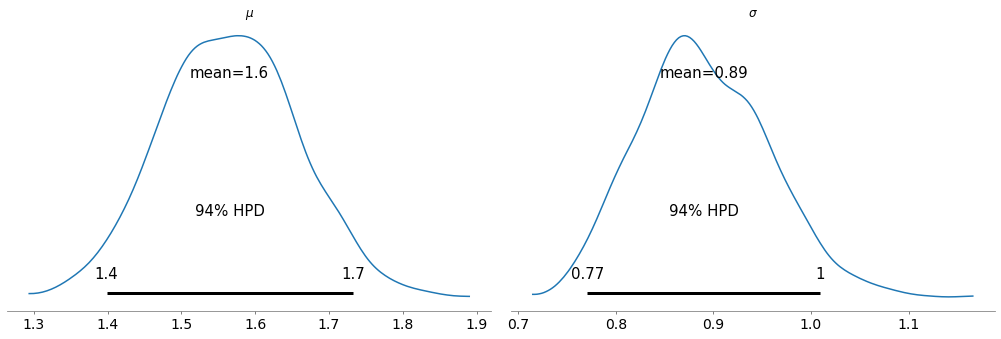

In [0]:
model = pm.Model()

with model:
    # Priors for unknown model parameters
    mu = pm.Normal('mu', mu=10, sigma=1)
    sigma = pm.HalfNormal('sigma', sigma=1)
    
    # Expected value of outcome
    y_obs = pm.Normal('y', mu=mu, sigma=sigma, observed=x)
    trace = pm.sample(draws=1000, chains=2, tune=1000, discard_tuned_samples=True)

ax = pm.plot_posterior(trace)
ax[0].set_title("$\mu$")
ax[1].set_title("$\sigma$")

bfgs_estimate = []
estimate = pm.find_MAP(model=model)
bfgs_estimate.append(estimate["mu"].item())
bfgs_estimate.append(estimate["sigma"].item())
mcmc_estimate = pm.summary(trace)['mean']

In [0]:
avg_mu_estimate = (mcmc_estimate[0] + bfgs_estimate[0]) / 2
error_mu = abs(true_mu - avg_mu_estimate)
print('MAP estimate for mu (BFGS method) = {:.2f}'.format(bfgs_estimate[0]))
print('MAP estimate for mu (MCMC method) = {:.2f}'.format(mcmc_estimate[0]))
print('MAP estimate for mu (Averaged) = {:.2f}'.format(avg_mu_estimate))
print('Error for mu = {:.2f} \n '.format(error_mu))

avg_sigma_estimate = (mcmc_estimate[1] + bfgs_estimate[1]) / 2
error_sigma = abs(true_sigma - avg_sigma_estimate)
print('MAP estimate for sigma (BFGS method) = {:.2f}'.format(bfgs_estimate[1]))
print('MAP estimate for sigma (MCMC method) = {:.2f}'.format(mcmc_estimate[1]))
print('MAP estimate for sigma (Averaged) = {:.2f}'.format(avg_sigma_estimate))
print('Error for sigma = {:.2f} \n '.format(error_sigma))

MAP estimate for mu (BFGS method) = 1.56
MAP estimate for mu (MCMC method) = 1.56
MAP estimate for mu (Averaged) = 1.56
Error for mu = 3.44 
 
MAP estimate for sigma (BFGS method) = 0.87
MAP estimate for sigma (MCMC method) = 0.89
MAP estimate for sigma (Averaged) = 0.88
Error for sigma = 0.12 
 


With an appropriate prior, we see that the MAP lies between the true mean, and the mean of our prior, which is expected. 

###Gamma Prior
Here let us assume we use a gamma prior, with a peak at 2. 

$γ$~$(α=2, β=1)$

Mean of gamma distribution: 4.39


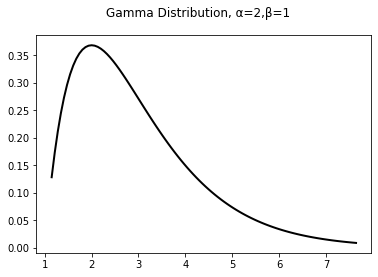

In [0]:
# Gamma distribution
from scipy.stats import gamma
fig, ax = plt.subplots(1, 1)
fig.suptitle('Gamma Distribution, α=2,β=1')
a = 2
b = 1
gamma_x = np.linspace(gamma.ppf(0.01, a, b),
                      gamma.ppf(0.99, a, b), 100)
gamma_dist = gamma(a,b)
ax.plot(gamma_x, gamma_dist.pdf(gamma_x), 'k-', lw=2)
print('Mean of gamma distribution: {:.2f}'.format(gamma_x.mean()))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, mu]
Sampling chain 1, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1483.04it/s]
logp = -176.51, ||grad|| = 79.966: 100%|██████████| 9/9 [00:00<00:00, 1114.09it/s]


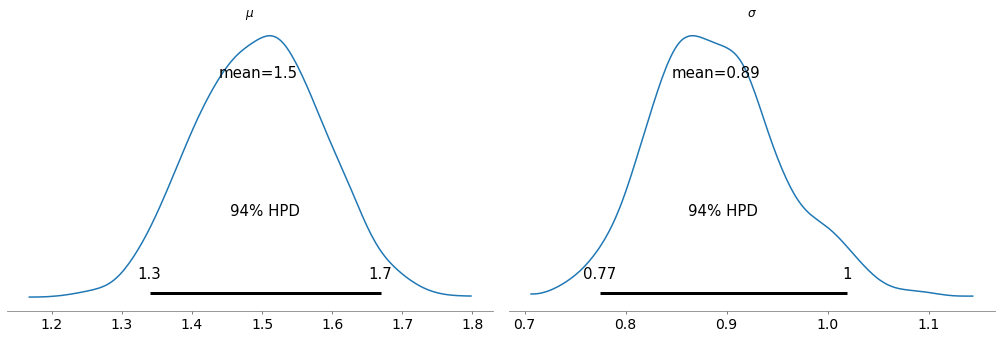

In [0]:
model = pm.Model()

with model:
    # Priors for unknown model parameters
    mu = pm.Gamma('mu', alpha=a, beta=b)
    # sigma = pm.HalfNorma('sigma', sigma=1)
    sigma = pm.Gamma('sigma', alpha=a, beta=b)

    # Expected value of outcome
    y_obs = pm.Normal('y', mu=mu, sigma=sigma, observed=x)

    trace = pm.sample(draws=1000, chains=2, tune=1000, discard_tuned_samples=True)

ax = pm.plot_posterior(trace)
ax[0].set_title("$\mu$")
ax[1].set_title("$\sigma$")

bfgs_estimate = []
estimate = pm.find_MAP(model=model)
bfgs_estimate.append(estimate["mu"].item())
bfgs_estimate.append(estimate["sigma"].item())
mcmc_estimate = pm.summary(trace)['mean']

In [0]:
avg_mu_estimate = (mcmc_estimate[0] + bfgs_estimate[0]) / 2
error_mu = abs(true_mu - avg_mu_estimate)
print('MAP estimate for mu (BFGS method) = {:.2f}'.format(bfgs_estimate[0]))
print('MAP estimate for mu (MCMC method) = {:.2f}'.format(mcmc_estimate[0]))
print('MAP estimate for mu (Averaged) = {:.2f}'.format(avg_mu_estimate))
print('Error for $\mu$ = {:.2f} \n '.format(error_mu))

avg_sigma_estimate = (mcmc_estimate[1] + bfgs_estimate[1]) / 2
error_sigma = abs(true_sigma - avg_sigma_estimate)
print('MAP estimate for sigma (BFGS method) = {:.2f}'.format(bfgs_estimate[1]))
print('MAP estimate for sigma (MCMC method) = {:.2f}'.format(mcmc_estimate[1]))
print('MAP estimate for sigma (Averaged) = {:.2f}'.format(avg_sigma_estimate))
print('Error for sigma = {:.2f} \n '.format(error_sigma))

MAP estimate for mu (BFGS method) = 1.50
MAP estimate for mu (MCMC method) = 1.50
MAP estimate for mu (Averaged) = 1.50
Error for $\mu$ = 3.50 
 
MAP estimate for sigma (BFGS method) = 0.88
MAP estimate for sigma (MCMC method) = 0.89
MAP estimate for sigma (Averaged) = 0.88
Error for sigma = 0.12 
 


We see in this case, the gamma distribution ~γ(α=2, β=1) performed much better than the previous normal distribution. 

### More Data

Text(0, 0.5, 'Count')

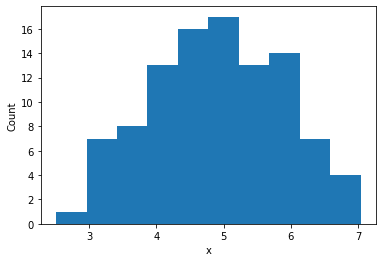

In [0]:
np.random.seed(100)

# size of dataset
N = 100

# Generate random data based on true parameter values
x = np.sqrt(true_sigma)*randn(N,1) + true_mu
plt.hist(x)
plt.xlabel('x')
plt.ylabel('Count')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, mu]
Sampling chain 1, 0 divergences: 100%|██████████| 1500/1500 [00:01<00:00, 1387.15it/s]
logp = -284.28, ||grad|| = 1,080.4: 100%|██████████| 18/18 [00:00<00:00, 1135.95it/s]  


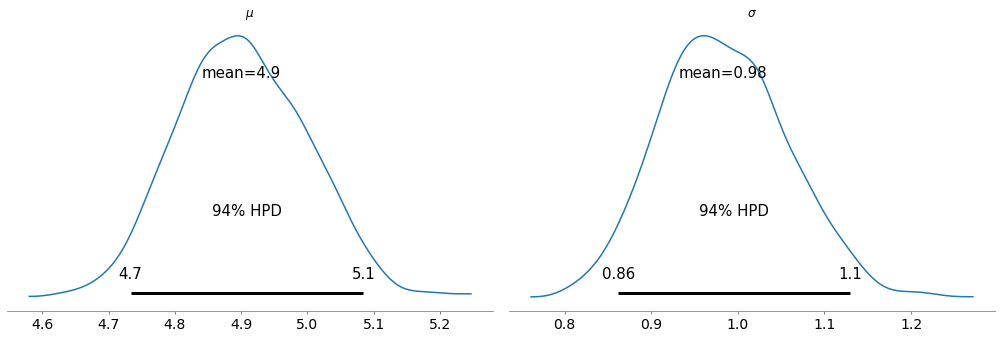

In [0]:
# Uniform Prior
model = pm.Model()

with model:
    # Priors for unknown model parameters
    mu = pm.Uniform('mu', lower=-10, upper=10)
    sigma = pm.Uniform('sigma', lower=0, upper=5)
    
    # Expected value of outcome
    y_obs = pm.Normal('y', mu=mu, sigma=sigma, observed=x)
    
    trace = pm.sample(draws=1000, chains=2, tune=500, discard_tuned_samples=True)
    
ax = pm.plot_posterior(trace)
ax[0].set_title("$\mu$")
ax[1].set_title("$\sigma$")

bfgs_estimate = []
estimate = pm.find_MAP(model=model)
bfgs_estimate.append(estimate["mu"].item())
bfgs_estimate.append(estimate["sigma"].item())
mcmc_estimate = pm.summary(trace)['mean']

In [0]:
avg_mu_estimate = (mcmc_estimate[0] + bfgs_estimate[0]) / 2
error_mu = abs(true_mu - avg_mu_estimate)
print('MAP estimate for mu (BFGS method) = {:.2f}'.format(bfgs_estimate[0]))
print('MAP estimate for mu (MCMC method) = {:.2f}'.format(mcmc_estimate[0]))
print('MAP estimate for mu (Averaged) = {:.2f}'.format(avg_mu_estimate))
print('Error for mu = {:.2f} \n '.format(error_mu))

avg_sigma_estimate = (mcmc_estimate[1] + bfgs_estimate[1]) / 2
error_sigma = abs(true_sigma - avg_sigma_estimate)
print('MAP estimate for sigma (BFGS method) = {:.2f}'.format(bfgs_estimate[1]))
print('MAP estimate for sigma (MCMC method) = {:.2f}'.format(mcmc_estimate[1]))
print('MAP estimate for sigma (Averaged) = {:.2f}'.format(avg_sigma_estimate))
print('Error for sigma = {:.2f} \n '.format(error_sigma))

MAP estimate for mu (BFGS method) = 4.90
MAP estimate for mu (MCMC method) = 4.90
MAP estimate for mu (Averaged) = 4.90
Error for mu = 0.10 
 
MAP estimate for sigma (BFGS method) = 0.97
MAP estimate for sigma (MCMC method) = 0.98
MAP estimate for sigma (Averaged) = 0.98
Error for sigma = 0.02 
 


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, mu]
Sampling chain 1, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1416.45it/s]
logp = -153.34, ||grad|| = 2.5817e-05: 100%|██████████| 23/23 [00:00<00:00, 1369.07it/s]  


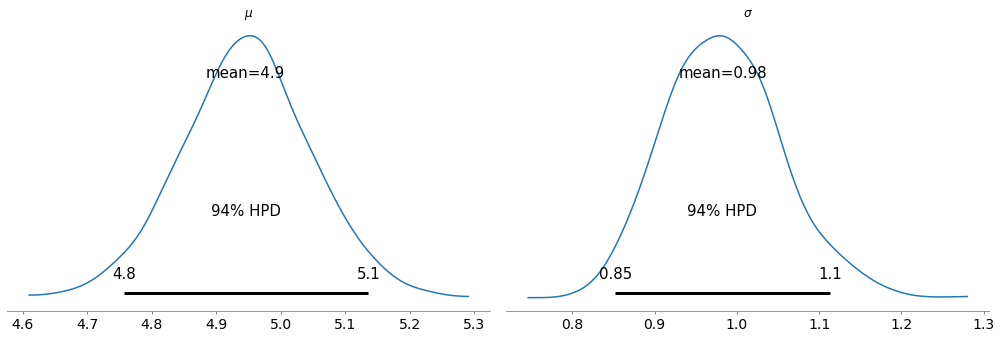

In [0]:
# Normal Prior
model = pm.Model()

with model:
    # Priors for unknown model parameters
    mu = pm.Normal('mu', mu=10, sigma=1)
    sigma = pm.HalfNormal('sigma', sigma=1)
    
    # Expected value of outcome
    y_obs = pm.Normal('y', mu=mu, sigma=sigma, observed=x)

    trace = pm.sample(draws=1000, chains=2, tune=1000, discard_tuned_samples=True)

ax = pm.plot_posterior(trace)
ax[0].set_title("$\mu$")
ax[1].set_title("$\sigma$")

bfgs_estimate = []
estimate = pm.find_MAP(model=model)
bfgs_estimate.append(estimate["mu"].item())
bfgs_estimate.append(estimate["sigma"].item())
mcmc_estimate = pm.summary(trace)['mean']

In [0]:
avg_mu_estimate = (mcmc_estimate[0] + bfgs_estimate[0]) / 2
error_mu = abs(true_mu - avg_mu_estimate)
print('MAP estimate for mu (BFGS method) = {:.2f}'.format(bfgs_estimate[0]))
print('MAP estimate for mu (MCMC method) = {:.2f}'.format(mcmc_estimate[0]))
print('MAP estimate for mu (Averaged) = {:.2f}'.format(avg_mu_estimate))
print('Error for $\mu$ = {:.2f} \n '.format(error_mu))

avg_sigma_estimate = (mcmc_estimate[1] + bfgs_estimate[1]) / 2
error_sigma = abs(true_sigma - avg_sigma_estimate)
print('MAP estimate for sigma (BFGS method) = {:.2f}'.format(bfgs_estimate[1]))
print('MAP estimate for sigma (MCMC method) = {:.2f}'.format(mcmc_estimate[1]))
print('MAP estimate for sigma (Averaged) = {:.2f}'.format(avg_sigma_estimate))
print('Error for sigma = {:.2f} \n '.format(error_sigma))

MAP estimate for mu (BFGS method) = 4.94
MAP estimate for mu (MCMC method) = 4.95
MAP estimate for mu (Averaged) = 4.94
Error for $\mu$ = 0.06 
 
MAP estimate for sigma (BFGS method) = 0.97
MAP estimate for sigma (MCMC method) = 0.98
MAP estimate for sigma (Averaged) = 0.97
Error for sigma = 0.03 
 


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, mu]
Sampling chain 1, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1379.99it/s]
logp = -143.82, ||grad|| = 24.185: 100%|██████████| 18/18 [00:00<00:00, 1403.09it/s]  


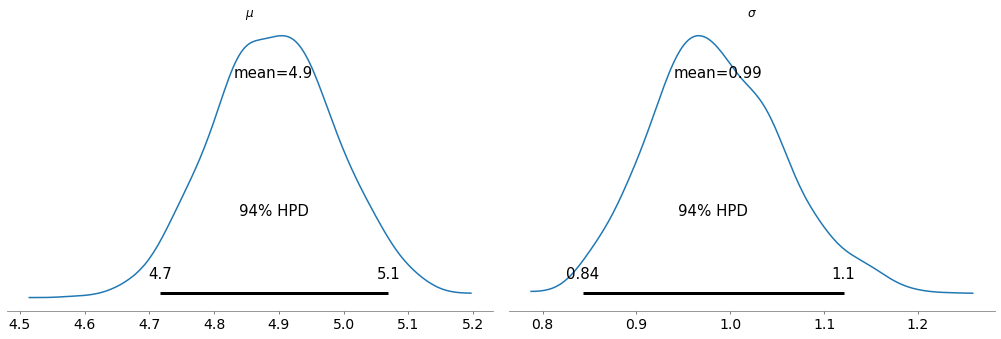

In [0]:
# Gamma Prior
model = pm.Model()

with model:
    # Priors for unknown model parameters
    mu = pm.Gamma('mu', alpha=a, beta=b)
    sigma = pm.Gamma('sigma', alpha=a, beta=b)

    # Expected value of outcome
    y_obs = pm.Normal('y', mu=mu, sigma=sigma, observed=x)

    trace = pm.sample(draws=1000, chains=2, tune=1000, discard_tuned_samples=True)

ax = pm.plot_posterior(trace)
ax[0].set_title("$\mu$")
ax[1].set_title("$\sigma$")

bfgs_estimate = []
estimate = pm.find_MAP(model=model)
bfgs_estimate.append(estimate["mu"].item())
bfgs_estimate.append(estimate["sigma"].item())
mcmc_estimate = pm.summary(trace)['mean']

In [0]:
avg_mu_estimate = (mcmc_estimate[0] + bfgs_estimate[0]) / 2
error_mu = abs(true_mu - avg_mu_estimate)
print('MAP estimate for mu (BFGS method) = {:.2f}'.format(bfgs_estimate[0]))
print('MAP estimate for mu (MCMC method) = {:.2f}'.format(mcmc_estimate[0]))
print('MAP estimate for mu (Averaged) = {:.2f}'.format(avg_mu_estimate))
print('Error for mu = {:.2f} \n '.format(error_mu))
print('$\mu$')

avg_sigma_estimate = (mcmc_estimate[1] + bfgs_estimate[1]) / 2
error_sigma = abs(true_sigma - avg_sigma_estimate)
print('MAP estimate for sigma (BFGS method) = {:.2f}'.format(bfgs_estimate[1]))
print('MAP estimate for sigma (MCMC method) = {:.2f}'.format(mcmc_estimate[1]))
print('MAP estimate for sigma (Averaged) = {:.2f}'.format(avg_sigma_estimate))
print('Error for sigma = {:.2f} \n '.format(error_sigma))

MAP estimate for mu (BFGS method) = 4.89
MAP estimate for mu (MCMC method) = 4.89
MAP estimate for mu (Averaged) = 4.89
Error for mu = 0.11 
 
$\mu$
MAP estimate for sigma (BFGS method) = 0.97
MAP estimate for sigma (MCMC method) = 0.99
MAP estimate for sigma (Averaged) = 0.98
Error for sigma = 0.02 
 


With more data, we see less weightage placed on our choice of prior, and MAP estimates tend to the true value of mu and sigma. 

## Problem 4: Poisson Distribution

Text(0, 0.5, 'Count')

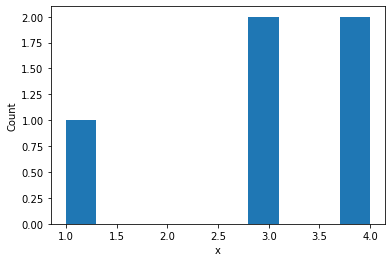

In [0]:
np.random.seed(100)

# true parameter value
true_mu = 3

# size of dataset
N = 5

x = np.random.poisson(true_mu, N)

plt.hist(x)
plt.xlabel('x')
plt.ylabel('Count')

###Uniform Prior

Mean of Uniform distribution: 5.00


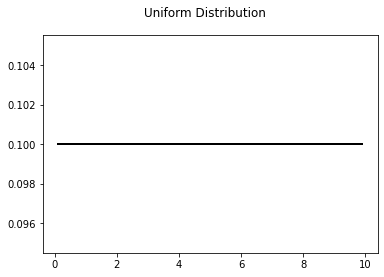

In [0]:
fig, ax = plt.subplots(1, 1)
fig.suptitle('Uniform Distribution')
uniform_x = np.linspace(uniform(0,10).ppf(0.01),
                        uniform(0,10).ppf(0.99), 100)
uniform_dist = uniform(0,10)
ax.plot(uniform_x, uniform_dist.pdf(uniform_x), 'k-', lw=2)
print('Mean of Uniform distribution: {:.2f}'.format(uniform_x.mean()))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [mu]
Sampling chain 1, 0 divergences: 100%|██████████| 1500/1500 [00:00<00:00, 2171.57it/s]
logp = -13.101, ||grad|| = 5: 100%|██████████| 6/6 [00:00<00:00, 693.45it/s]


Text(0.5, 1.0, '$\\mu$')

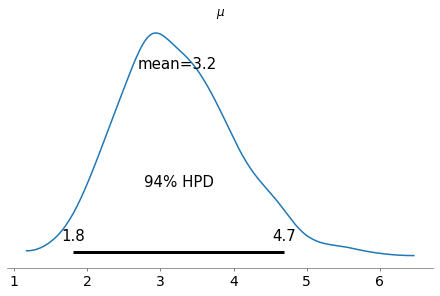

In [0]:
model = pm.Model()

with model:
    # Priors for unknown model parameters
    mu = pm.Uniform('mu', lower=0, upper=10)
    
    # Expected value of outcome
    y_obs = pm.Poisson('y', mu=mu, observed=x)

    trace = pm.sample(draws=1000, chains=2, tune=500, discard_tuned_samples=True)

bfgs_estimate = pm.find_MAP(model=model)['mu'].item()
mcmc_estimate = pm.summary(trace)['mean'][0]
ax = pm.plot_posterior(trace)
ax[0].set_title("$\mu$")

In [0]:
avg_estimate = (mcmc_estimate + bfgs_estimate) / 2
error = abs(true_mu - avg_estimate)
print('\nMAP Estimate (BFGS method) = {:.2f}'.format(bfgs_estimate))
print('MAP Estimate (MCMC method) = {:.2f}'.format(mcmc_estimate))
print('MAP Estimate (Averaged) = {:.2f}'.format(avg_estimate))
print('Error = {:.2f}'.format(error))


MAP Estimate (BFGS method) = 3.00
MAP Estimate (MCMC method) = 3.23
MAP Estimate (Averaged) = 3.11
Error = 0.11


###Gamma Prior

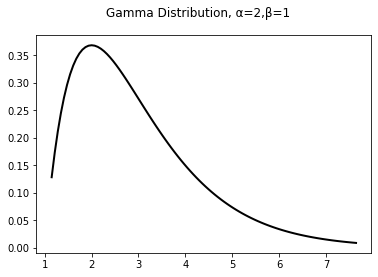

In [0]:
# Gamma distribution
fig, ax = plt.subplots(1, 1)
fig.suptitle('Gamma Distribution, α=2,β=1')
a = 2
b = 1
gamma_x = np.linspace(gamma.ppf(0.01, a, b),
                      gamma.ppf(0.99, a, b), 100)
gamma_dist = gamma(a,b)
ax.plot(gamma_x, gamma_dist.pdf(gamma_x), 'k-', lw=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [mu]
Sampling chain 1, 0 divergences: 100%|██████████| 2000/2000 [00:00<00:00, 2085.89it/s]
logp = -10.849, ||grad|| = 4: 100%|██████████| 7/7 [00:00<00:00, 1502.80it/s]


Text(0.5, 1.0, '$\\mu$')

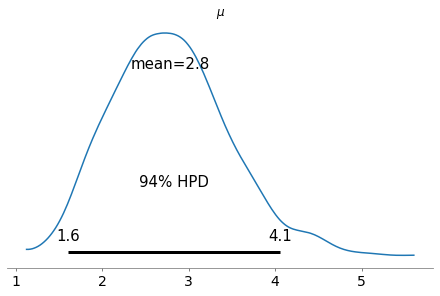

In [0]:
model = pm.Model()

with model:
    # Priors for unknown model parameters
    mu = pm.Gamma('mu', alpha=a, beta=b)
    
    # Expected value of outcome
    y_obs = pm.Poisson('y', mu=mu, observed=x)

    trace = pm.sample(draws=1000, chains=2, tune=1000, discard_tuned_samples=True)

bfgs_estimate = pm.find_MAP(model=model)['mu'].item()
mcmc_estimate = pm.summary(trace)['mean'][0]
ax = pm.plot_posterior(trace)
ax[0].set_title("$\mu$")

In [0]:
avg_estimate = (mcmc_estimate + bfgs_estimate) / 2
error = abs(true_mu - avg_estimate)
print('\nMAP Estimate (BFGS method) = {:.2f}'.format(bfgs_estimate))
print('MAP Estimate (MCMC method) = {:.2f}'.format(mcmc_estimate))
print('MAP Estimate (Averaged) = {:.2f}'.format(avg_estimate))
print('Error = {:.2f}'.format(error))


MAP Estimate (BFGS method) = 2.67
MAP Estimate (MCMC method) = 2.79
MAP Estimate (Averaged) = 2.73
Error = 0.27


### Normal Prior

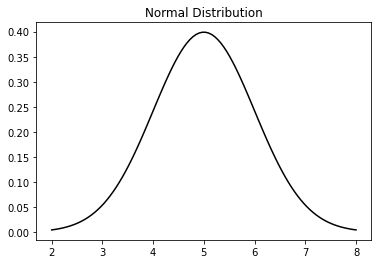

In [0]:
fig, ax = plt.subplots(1, 1)
mu = 5
sigma = 1
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
ax.plot(x, stats.norm.pdf(x, mu, sigma), 'k-')
ax.set_title("Normal Distribution")
x = np.linspace(0, 3*sigma, 100)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [mu]
Sampling chain 1, 0 divergences: 100%|██████████| 2000/2000 [00:00<00:00, 2152.42it/s]
logp = -361.42, ||grad|| = 79.6: 100%|██████████| 4/4 [00:00<00:00, 513.71it/s]


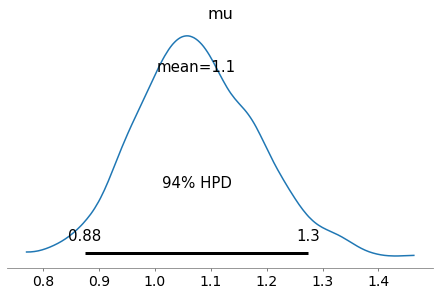

In [0]:
model = pm.Model()

with model:
    # Priors for unknown model parameters
    mu = pm.Normal('mu', mu=5, sigma=1)
    
    # Expected value of outcome
    y_obs = pm.Poisson('y', mu=mu, observed=x)

    trace = pm.sample(draws=1000, chains=2, tune=1000, discard_tuned_samples=True)

bfgs_estimate = pm.find_MAP(model=model)['mu'].item()
mcmc_estimate = pm.summary(trace)['mean'][0]
ax = pm.plot_posterior(trace)

In [0]:
avg_estimate = (mcmc_estimate + bfgs_estimate) / 2
error = abs(true_mu - avg_estimate)
print('\nMAP Estimate (BFGS method) = {:.2f}'.format(bfgs_estimate))
print('MAP Estimate (MCMC method) = {:.2f}'.format(mcmc_estimate))
print('MAP Estimate (Averaged) = {:.2f}'.format(avg_estimate))
print('Error = {:.2f}'.format(error))


MAP Estimate (BFGS method) = 0.00
MAP Estimate (MCMC method) = 1.07
MAP Estimate (Averaged) = 0.54
Error = 2.46


### More Data

Text(0, 0.5, 'Count')

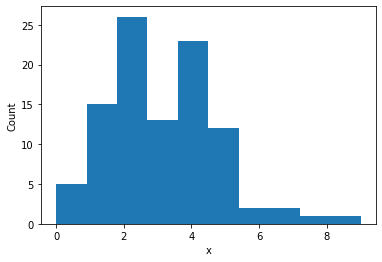

In [0]:
np.random.seed(100)

# true parameter value
true_mu = 3

# size of dataset
N = 100

x = np.random.poisson(true_mu, N)

plt.hist(x)
plt.xlabel('x')
plt.ylabel('Count')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [mu]
Sampling chain 1, 0 divergences: 100%|██████████| 1500/1500 [00:00<00:00, 2176.77it/s]
logp = -243.34, ||grad|| = 99.5: 100%|██████████| 7/7 [00:00<00:00, 1429.41it/s]


Text(0.5, 1.0, '$\\mu$')

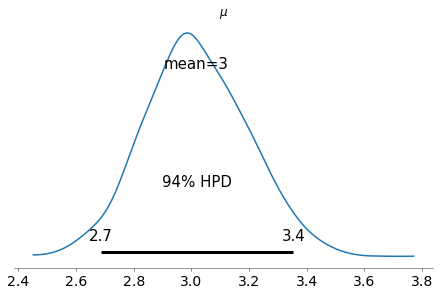

In [0]:
# Uniform Prior
model = pm.Model()

with model:
    # Priors for unknown model parameters
    mu = pm.Uniform('mu', lower=0, upper=10)
    
    # Expected value of outcome
    y_obs = pm.Poisson('y', mu=mu, observed=x)

    trace = pm.sample(draws=1000, chains=2, tune=500, discard_tuned_samples=True)

bfgs_estimate = pm.find_MAP(model=model)['mu'].item()
mcmc_estimate = pm.summary(trace)['mean'][0]
ax = pm.plot_posterior(trace)
ax[0].set_title("$\mu$")

In [0]:
avg_estimate = (mcmc_estimate + bfgs_estimate) / 2
error = abs(true_mu - avg_estimate)
print('\nMAP Estimate (BFGS method) = {:.2f}'.format(bfgs_estimate))
print('MAP Estimate (MCMC method) = {:.2f}'.format(mcmc_estimate))
print('MAP Estimate (Averaged) = {:.2f}'.format(avg_estimate))
print('Error = {:.2f}'.format(error))


MAP Estimate (BFGS method) = 3.01
MAP Estimate (MCMC method) = 3.02
MAP Estimate (Averaged) = 3.01
Error = 0.01


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [mu]
Sampling chain 1, 0 divergences: 100%|██████████| 2000/2000 [00:00<00:00, 2055.47it/s]
logp = -218.14, ||grad|| = 100: 100%|██████████| 8/8 [00:00<00:00, 1342.12it/s]


Text(0.5, 1.0, '$\\mu$')

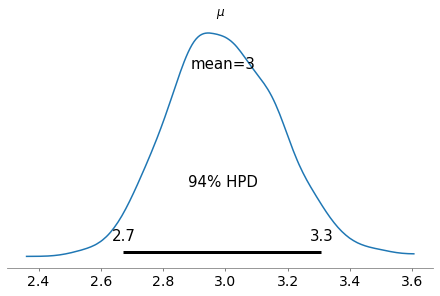

In [0]:
# Gamma Prior
model = pm.Model()

with model:
    # Priors for unknown model parameters
    mu = pm.Gamma('mu', alpha=a, beta=b)
    
    # Expected value of outcome
    y_obs = pm.Poisson('y', mu=mu, observed=x)

    trace = pm.sample(draws=1000, chains=2, tune=1000, discard_tuned_samples=True)

bfgs_estimate = pm.find_MAP(model=model)['mu'].item()
mcmc_estimate = pm.summary(trace)['mean'][0]
ax = pm.plot_posterior(trace)
ax[0].set_title("$\mu$")

In [0]:
avg_estimate = (mcmc_estimate + bfgs_estimate) / 2
error = abs(true_mu - avg_estimate)
print('\nMAP Estimate (BFGS method) = {:.2f}'.format(bfgs_estimate))
print('MAP Estimate (MCMC method) = {:.2f}'.format(mcmc_estimate))
print('MAP Estimate (Averaged) = {:.2f}'.format(avg_estimate))
print('Error = {:.2f}'.format(error))


MAP Estimate (BFGS method) = 2.99
MAP Estimate (MCMC method) = 2.99
MAP Estimate (Averaged) = 2.99
Error = 0.01


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [mu]
Sampling chain 1, 0 divergences: 100%|██████████| 2000/2000 [00:00<00:00, 2157.57it/s]
logp = -241.95, ||grad|| = 39.8: 100%|██████████| 9/9 [00:00<00:00, 1068.10it/s]


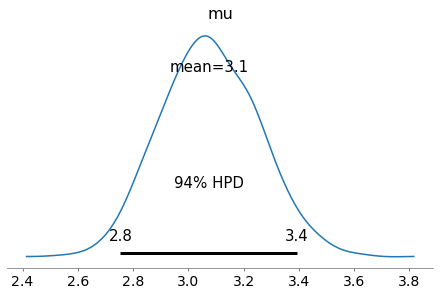

In [0]:
model = pm.Model()

with model:
    # Priors for unknown model parameters
    mu = pm.Normal('mu', mu=5, sigma=1)
    
    # Expected value of outcome
    y_obs = pm.Poisson('y', mu=mu, observed=x)

    trace = pm.sample(draws=1000, chains=2, tune=1000, discard_tuned_samples=True)

bfgs_estimate = pm.find_MAP(model=model)['mu'].item()
mcmc_estimate = pm.summary(trace)['mean'][0]
ax = pm.plot_posterior(trace)

In [0]:
avg_estimate = (mcmc_estimate + bfgs_estimate) / 2
error = abs(true_mu - avg_estimate)
print('\nMAP Estimate (BFGS method) = {:.2f}'.format(bfgs_estimate))
print('MAP Estimate (MCMC method) = {:.2f}'.format(mcmc_estimate))
print('MAP Estimate (Averaged) = {:.2f}'.format(avg_estimate))
print('Error = {:.2f}'.format(error))


MAP Estimate (BFGS method) = 3.07
MAP Estimate (MCMC method) = 3.08
MAP Estimate (Averaged) = 3.07
Error = 0.07


---
# Q3 - Comparing prediction errors between MLE and MAP solutions on Real Datasets
---

## Problem 1: SKLearn Boston Housing Price Dataset

First, we load the dataset and do some exploratory data analysis

In [0]:
boston = sklearn.datasets.load_boston()
X = pd.DataFrame(boston.data, columns=boston.feature_names)
y = boston.target

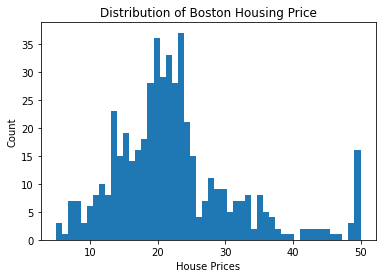

In [0]:
plt.hist(y, bins=50)
plt.xlabel('House Prices')
plt.ylabel('Count')
plt.title('Distribution of Boston Housing Price')
plt.show()

As we can see, the target y, seems to be normally distributed but with some outliers after ~48. The mean seems to lie between 20-25 

In [0]:
X.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


In [0]:
X.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000


Now we build the models. <br>
First we split the data into training and testing with a ratio of 0.2.

In [0]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.2, random_state=42)

In [0]:
print("Size of X train:", X_train.size)
print("Size of X test:", X_test.size)
print("Size of y train:", y_train.size)
print("Size of y test:", y_test.size)

Size of X train: 5252
Size of X test: 1326
Size of y train: 404
Size of y test: 102


###Linear Regression Model

Our models will be based on the linear regression model with squared errors.

Consider the standard equation of a linear regression model $y = bx + a$, where $y$ is our variable of interest, $b$ is the weight assigned to each input x and $a$ is the intercept.

In probabilistic terms, we reframe the model as follows: <br>
Let the expected value $\mu$ of our variable of interest $y$ be: $y = \alpha + \sum_{i=0}^{d}{\beta_ix_i}$, <br>
where $d$ is the dimension of the input $x$. <br>
Now, we observed the distribution of our dependent variable $y$ which in this case is Normal. Note that $\mu$ is also the mean of the distribution. 

So then,

$ y \sim \mathcal{N}(\mu, \sigma^2) = \mathcal{N}(\alpha + \sum_{i=0}^{d}{\beta_ix_i}, \sigma^2)$ \\

It then suffices, that we need to find $\alpha, \beta$ and $\sigma^2$ using their lilelihoods. 

For the MAP, we can further specify the prior distributions of these parameters but for the MLE, this information is not incorporated so they are uniformly distributed.

###MLE Model

The MLE model is built using a MAP model but with uninformative Uniform priors

In [0]:
mle_model = pm.Model()

with mle_model:
    # Priors for unknown model parameters
    alpha = pm.Uniform('alpha', lower=-20, upper=20)
    beta = pm.Uniform('beta', lower=-20, upper=20, shape=len(X_train.columns))
    sigma = pm.Uniform('sigma', lower=0, upper=15)

    # Expected value of outcome
    mu = alpha
    for i in range(len(X_train.columns)):
        mu += beta[i] *  X_train.iloc[:, i].to_numpy()


    # Likelihood (sampling distribution) of observations
    y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=y_train)

In [0]:
mle_estimate = pm.find_MAP(model=mle_model)
mle_estimate

logp = -1,251.1, ||grad|| = 2,208.3: 100%|██████████| 3068/3068 [00:02<00:00, 1293.30it/s]


{'alpha': array(18.6511),
 'alpha_interval__': array(3.3553),
 'beta': array([-1.0832e-01,  3.0972e-02,  5.0806e-02,  2.8463e+00, -1.4930e+01,
         5.2073e+00, -5.4780e-03, -1.2915e+00,  2.1052e-01, -8.9348e-03,
        -7.3875e-01,  1.4285e-02, -4.6649e-01]),
 'beta_interval__': array([-1.0832e-02,  3.0972e-03,  5.0806e-03,  2.8657e-01, -1.9300e+00,
         5.3299e-01, -5.4780e-04, -1.2933e-01,  2.1053e-02, -8.9348e-04,
        -7.3909e-02,  1.4285e-03, -4.6657e-02]),
 'sigma': array(4.7006),
 'sigma_interval__': array(-0.7844)}

### MAP Model

The MAP model will be built with 0-mean Gaussians for the alpha and beta priors and a half normal for the sigma as it it cannot be negative

In [0]:
map_model = pm.Model()

with map_model:
    # Priors for unknown model parameters
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=10, shape=len(X_train.columns))
    sigma = pm.HalfNormal('sigma', sd=1)

    # Expected value of outcome
    mu = alpha
    for i in range(len(X_train.columns)):
        mu += beta[i] *  X_train.iloc[:, i].to_numpy()

    # Likelihood (sampling distribution) of observations
    y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=y_train)

In [0]:
map_estimate = pm.find_MAP(model=map_model)
map_estimate

logp = -1,255, ||grad|| = 4.4149: 100%|██████████| 1769/1769 [00:01<00:00, 1083.09it/s]


{'alpha': array(19.8405),
 'beta': array([-1.0825e-01,  3.1893e-02,  2.2408e-02,  2.8756e+00, -1.1194e+01,
         4.9634e+00, -1.0219e-02, -1.3004e+00,  2.1876e-01, -9.8652e-03,
        -7.5592e-01,  1.3730e-02, -4.8661e-01]),
 'sigma': array(4.5556),
 'sigma_log__': array(1.5164)}

### Model Evaluation
We define methods to predict and evaluate the models using the squared loss

In [0]:
def predict(estimates, x):
    alpha = estimates['alpha']
    beta = estimates['beta']
    sigma = estimates['sigma']

    return alpha + sum([beta[i] * x[i] for i in range(len(x))])

def evaluate(estimates, X_test, y_test):
    weights = np.copy(estimates['beta'])
    weights = np.insert(weights, 0, estimates['alpha'], axis=0)
    X = X_test.copy()
    X.insert(0, 'Ones', 1)
    X = X.to_numpy()
    y_pred = np.dot(X, weights.T)

    squared_error = ((y_test - y_pred) ** 2).mean()
    return squared_error, y_pred


Let's compute the mean squared error of the predictions.

In [0]:
error, y_mle = evaluate(mle_estimate, X_test, y_test)
print(f"MLE Sqaured Error: {error}")
error, y_map = evaluate(map_estimate, X_test, y_test)
print(f"MAP Sqaured Error: {error}")

MLE Sqaured Error: 25.982671511031953
MAP Sqaured Error: 25.42747447599459


As we can see, the MAP model does better generally

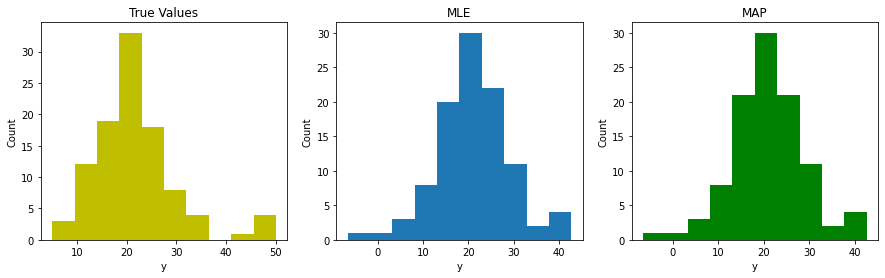

In [0]:
fig, ax = plt.subplots(1,3, figsize=(15,4))
ax[0].hist(y_test, color='y')
ax[1].hist(y_mle, label='MLE')
ax[2].hist(y_map, color='g')
ax[0].set_title('True Values')
ax[0].set_xlabel('y')
ax[0].set_ylabel('Count')
ax[1].set_title('MLE')
ax[1].set_xlabel('y')
ax[1].set_ylabel('Count')
ax[2].set_title('MAP')
ax[2].set_xlabel('y')
ax[2].set_ylabel('Count')
plt.show()

## Problem 2: Bike Sharing Dataset

First, we load the dataset and do some exploratory data analysis

In [0]:
#Path name to the data.csv
filepath = "https://raw.githubusercontent.com/jxlim89/CS5340/master/data/BikeSharing/hour.csv"
hour = pd.read_csv(filepath)

In [0]:
hour.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


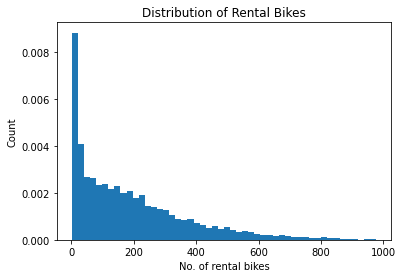

In [0]:
#check the distribution of the data.
plt.hist(hour.cnt, bins=50, density=True)
plt.xlabel('No. of rental bikes')
plt.ylabel('Count')
plt.title('Distribution of Rental Bikes')
plt.show()

Text(0.5, 1.0, 'Temporal Distribution of Rental Bikes')

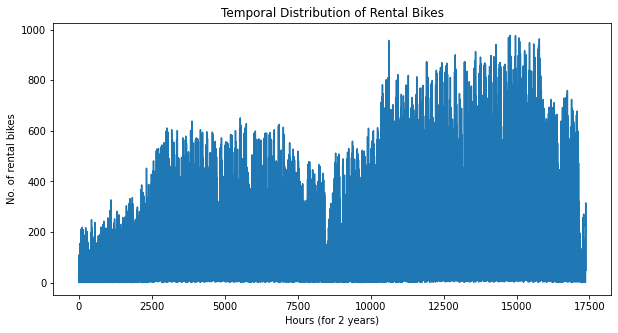

In [0]:
#Plot the number of rented bikes between this 2 years. Overall is still increasing
fig, axes = plt.subplots(1, 1, sharex=False, figsize=(10,5))

axes.plot(hour.instant, hour.cnt)
axes.set_ylabel('No. of rental bikes')
axes.set_xlabel('Hours (for 2 years)')
axes.set_title('Temporal Distribution of Rental Bikes')

Now we build the models.

In [0]:
#Split data here
train, test = train_test_split(hour, test_size=0.2, random_state=42)

#sort them in ascending order to maintain the temporal order
train = train.sort_index()
test = test.sort_index()

print(train.shape)
print(test.shape)

(13903, 17)
(3476, 17)


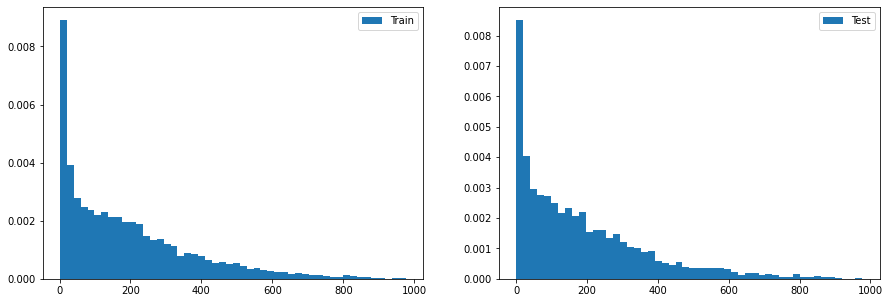

In [0]:
#Check the distribution of the train and test set
fig, axes = plt.subplots(1, 2, sharex=False, figsize=(15,5))
axes[0].hist(train.cnt, bins=50, density=True, label = 'Train')
axes[1].hist(test.cnt, bins=50, density=True, label = 'Test')
axes[0].legend()
axes[1].legend()

### Poisson Regression Model

Data seems to have a Poisson distribution. As it is base on the event of the number of bike rental per hour for the period of 2 years. To keep things simple we will be using a linear model for the prediction. We will be using the Poisson regression model
https://en.wikipedia.org/wiki/Poisson_regression<br>
$$
\mu = exp(x\theta)
$$
We shall use the Poisson Distribution to model the likelyhood. The Poisson distribution is given by https://en.wikipedia.org/wiki/Poisson_distribution:
$$
Pr(X=x|\mu) = Pois(\mu) = \frac{\mu^{x} e^{-\mu}}{x!}
$$
Estimation of the parameter theta by using loglikely hood (MLE), 
$$
LL(\theta) = \sum \big(xlog(\mu) - \mu\big)
$$

Since the data consists of some temporal variables like year, mnth, weekday and hr. We will only use them in our model <br>
$$
\mu =  exp(year*\theta_0+ mnth*\theta_1 + weekday*\theta_2 + hr*\theta_3)
$$

In [0]:
train.describe()

,instant,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,13903.000000,13903.000000,13903.000000,13903.000000,13903.000000,13903.000000,13903.000000,13903.000000,13903.000000,13903.000000,13903.000000,13903.000000,13903.000000,13903.000000,13903.000000,13903.000000
mean,8697.040135,2.509243,0.502050,6.552974,11.557146,0.028699,2.998202,0.679566,1.426023,0.497396,0.476183,0.627011,0.189822,36.002374,154.574696,190.577070
std,5024.565656,1.106817,0.500014,3.436925,6.911927,0.166965,2.011350,0.466660,0.638842,0.193017,0.172308,0.192801,0.122293,49.636195,152.035090,182.220507
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,4355.500000,2.000000,0.000000,4.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.470000,0.104500,4.000000,34.000000,39.000000
50%,8677.000000,3.000000,1.000000,7.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.164200,17.000000,116.000000,143.000000
75%,13077.500000,3.000000,1.000000,10.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.621200,0.780000,0.253700,49.000000,221.500000,282.000000
max,17379.000000,4.000000,1.000000,12.000000,23.000000,1.000000,6.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,367.000000,885.000000,976.000000


In [0]:
train.iloc[1,16]

40

### MLE Model

In [0]:
# functions for the negative log likely hood and Prediction.
def negloglike(theta, cnt, year, mth, day, hr):
    mu = np.exp(theta[0]+theta[1]*year + theta[2]*mth+ theta[3]*day+ theta[4]*hr)
    nll= -sum(cnt*(np.log(mu)) - mu)
    return nll
def predict_cnt(theta, year, mth, day, hr):
    estimated_cnt = np.exp(theta[0] + theta[1]*year+ theta[2]*mth+ theta[3]*day+theta[4]*hr)
    return estimated_cnt

In [0]:
#Set a high number to allow the optimizer to minimize successfully
maxNumberIters =  train.cnt.count()*1000
print(maxNumberIters)

#Using an off-the-shelve optimizer similar to those used in lecture
params_MLE = optimize.minimize(negloglike,np.array([0,0,0,0,0]), args=(train.cnt,train.yr,train.mnth,train.weekday, train.hr), options={'maxiter': maxNumberIters}, method='Nelder-Mead')
print(params_MLE)

13903000
 final_simplex: (array([[3.9568, 0.506 , 0.0363, 0.0126, 0.0563],
       [3.9568, 0.506 , 0.0363, 0.0126, 0.0563],
       [3.9568, 0.506 , 0.0363, 0.0126, 0.0563],
       [3.9568, 0.506 , 0.0363, 0.0126, 0.0563],
       [3.9568, 0.506 , 0.0363, 0.0126, 0.0563],
       [3.9568, 0.506 , 0.0363, 0.0126, 0.0563]]), array([-11553173.0979, -11553173.0979, -11553173.0978, -11553173.0978,
       -11553173.0978, -11553173.0978]))
           fun: -11553173.097859707
       message: 'Optimization terminated successfully.'
          nfev: 1160
           nit: 723
        status: 0
       success: True
             x: array([3.9568, 0.506 , 0.0363, 0.0126, 0.0563])


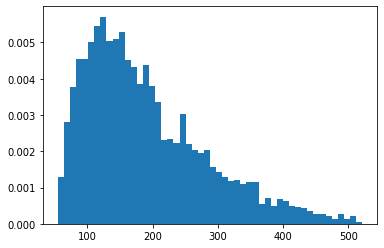

In [0]:
predictionMLE_cnt = predict_cnt(params_MLE.x, test.yr,test.mnth, test.weekday, test.hr)

#print(predictionMLE_cnt)
#Prediction looks like the gamma distribution
plt.hist(predictionMLE_cnt, bins=50, density=True)
plt.show()

### MAP Model

For MAP, we will need to calculate the posterior. We will be using gamma as the congugate prior for the Poisson distribution.
Hence, the posterior will also be a Gamma distribution
$$
Pr(\mu|X) = Pr(X|\mu) Pr(\mu) = Pois(\mu)*Gamma(\alpha,\beta) =\frac{\mu^{x} e^{-\mu}}{x!} \frac{\beta^{\alpha}\mu^{\alpha-1}e^{-\beta \mu}}{\Gamma(\alpha)}
$$
$$
                                    \propto \mu^{x} e^{-\mu} \mu^{\alpha-1}e^{-\beta \mu}\\
                                    \propto \mu^{x+\alpha - 1} e^{-\mu(\beta+1)}
$$
The updated gamma parameters are as:
$$
 Gamma(\alpha + x, \beta - \mu)
$$
Now maximize the log MAP:
$$
LL(\theta) = \sum \big((x+\alpha-1).log(\mu) -\mu \beta - \mu \big)
$$

In [0]:
# using an optimizer
def neglogpost(theta,cnt, year, mth, day, hr,a,b):
    mu = np.exp(theta[0]+theta[1]*year + theta[2]*mth+ theta[3]*day+ theta[4]*hr)
    
    nlpost= -sum((cnt+a-1)*np.log(mu) - mu*b -mu)
    return nlpost


The alpha and beta parameters of the gamma distribution is calculated by fitting a gamma distribution over the training data. https://en.wikipedia.org/wiki/Gamma_distribution

0.830845944586797 0 229.3771437880304


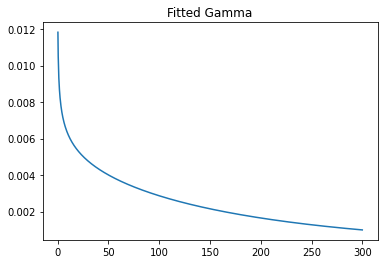

0.830845944586797
0.004359632278463235


In [0]:
shape, loc, scale = stats.gamma.fit(train.cnt, floc=0)
print(shape, loc, scale)
x = np.linspace(0,300,1000)
y = stats.gamma.pdf(x, shape, loc, scale)
plt.title('Fitted Gamma')
plt.plot(x, y)
plt.show()

alphag = shape
betag = 1/scale
print(alphag)
print(betag)

In [0]:
#Use off-the-shelf optimizer to retrieve the parameters value
params_MAP = optimize.minimize(neglogpost,np.array([0,0,0,0,0]), args=(train.cnt, train.yr, train.mnth, train.weekday, train.hr, alphag,betag),options={'maxiter': maxNumberIters}, method='Nelder-Mead')

print(params_MAP)

 final_simplex: (array([[3.9503, 0.5065, 0.0363, 0.0126, 0.0564],
       [3.9503, 0.5065, 0.0363, 0.0126, 0.0563],
       [3.9503, 0.5065, 0.0363, 0.0126, 0.0563],
       [3.9503, 0.5064, 0.0363, 0.0126, 0.0563],
       [3.9503, 0.5065, 0.0363, 0.0126, 0.0563],
       [3.9503, 0.5064, 0.0363, 0.0126, 0.0563]]), array([-11529577.8137, -11529577.8137, -11529577.8136, -11529577.8136,
       -11529577.8136, -11529577.8136]))
           fun: -11529577.813669205
       message: 'Optimization terminated successfully.'
          nfev: 1344
           nit: 830
        status: 0
       success: True
             x: array([3.9503, 0.5065, 0.0363, 0.0126, 0.0564])


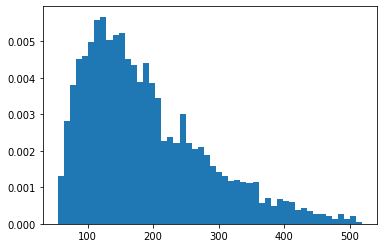

In [0]:
predictionMAP_cnt = predict_cnt(params_MAP.x, test.yr,test.mnth, test.weekday, test.hr)

#print(predictionMAP_cnt)
#Prediction looks like the gamma distribution too
plt.hist(predictionMAP_cnt, bins=50, density=True)
plt.show()

### Model Evaluation

Compare the MLE and MAP predictions.

In [0]:
#Calculate the Mean Square Error
mu_mle = params_MLE
mu_map = params_MAP

y = np.arange(0,  200)

print("MLE MSE error: ",mean_squared_error(test.cnt, predictionMLE_cnt))
print("MAP MSE error: ",mean_squared_error(test.cnt, predictionMAP_cnt))

MLE MSE error:  26717.269774374276
MAP MSE error:  26695.290537743673


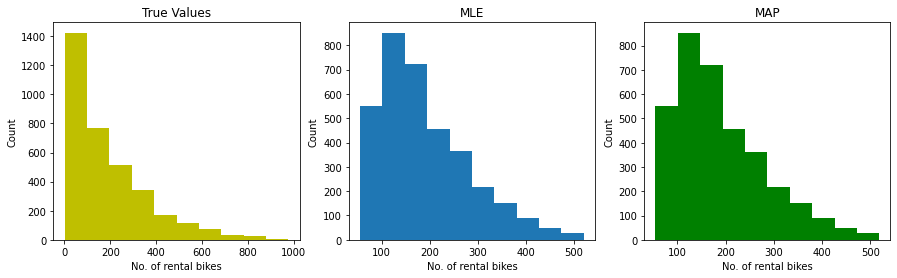

In [0]:
fig, ax = plt.subplots(1,3, figsize=(15,4))
ax[0].hist(test.cnt, color='y')
ax[1].hist(predictionMLE_cnt, label='MLE')
ax[2].hist(predictionMAP_cnt, color='g')
ax[0].set_title('True Values')
ax[0].set_xlabel('No. of rental bikes')
ax[0].set_ylabel('Count')
ax[1].set_title('MLE')
ax[1].set_xlabel('No. of rental bikes')
ax[1].set_ylabel('Count')
ax[2].set_title('MAP')
ax[2].set_xlabel('No. of rental bikes')
ax[2].set_ylabel('Count')
plt.show()

We could see that the MAP predictions are a bit better than the MLE predictions, we assumed its the gamma prior that helps the data to fit better. As there are quite a large number of samples used, the MAP predictions are quite similar to the MLE predictions too<br>

Overall, the results aligned with our analysis.

(*Ignore the large error as we used a simpler model (lesser features incorporated) for a complex dataset , the key point we are studying is the difference between the MLE and MAP predictions*)
